In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
from sklearn.decomposition import PCA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()[:, pred_start:pred_end]
pro_s1d2 = pro_s1d2.X.toarray()[:, pred_start:pred_end]
pro_s1d3 = pro_s1d3.X.toarray()[:, pred_start:pred_end]
pro_s2d1 = pro_s2d1.X.toarray()[:, pred_start:pred_end]
pro_s2d4 = pro_s2d4.X.toarray()[:, pred_start:pred_end]
pro_s2d5 = pro_s2d5.X.toarray()[:, pred_start:pred_end]

pro_s3d1 = pro_s3d1.X.toarray()[:, pred_start:pred_end]
pro_s3d6 = pro_s3d6.X.toarray()[:, pred_start:pred_end]
pro_s3d7 = pro_s3d7.X.toarray()[:, pred_start:pred_end]

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()[:, pred_start:pred_end]
pro_s4d8 = pro_s4d8.X.toarray()[:, pred_start:pred_end]
pro_s4d9 = pro_s4d9.X.toarray()[:, pred_start:pred_end]

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 1)


In [17]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [18]:
# batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
# batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
# batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [19]:
# train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
# train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

# val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
# val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

# test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
# test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [20]:
# train_input = train_input + val_input
# train_output = train_output + val_output

In [21]:
# train_input = np.concatenate(train_input, axis=0)
# val_input = np.concatenate(val_input, axis=0)
# test_input = np.concatenate(test_input, axis=0)

# train_output = np.concatenate(train_output, axis=0)
# val_output = np.concatenate(val_output, axis=0)
# test_output = np.concatenate(test_output, axis=0)

In [22]:
test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

test_input = np.concatenate(test_input, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [23]:
print(test_input.shape)
print(test_output.shape)

(1000, 13953)
(1000, 1)


In [24]:
RNA_s1d1 = torch.from_numpy(RNA_s1d1)
RNA_s1d2 = torch.from_numpy(RNA_s1d2)
RNA_s1d3 = torch.from_numpy(RNA_s1d3)
RNA_s2d1 = torch.from_numpy(RNA_s2d1)
RNA_s2d4 = torch.from_numpy(RNA_s2d4)
RNA_s2d5 = torch.from_numpy(RNA_s2d5)
RNA_s3d1 = torch.from_numpy(RNA_s3d1)
RNA_s3d6 = torch.from_numpy(RNA_s3d6)
RNA_s3d7 = torch.from_numpy(RNA_s3d7)
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

In [25]:
pro_s1d1 = torch.from_numpy(pro_s1d1)
pro_s1d2 = torch.from_numpy(pro_s1d2)
pro_s1d3 = torch.from_numpy(pro_s1d3)
pro_s2d1 = torch.from_numpy(pro_s2d1)
pro_s2d4 = torch.from_numpy(pro_s2d4)
pro_s2d5 = torch.from_numpy(pro_s2d5)
pro_s3d1 = torch.from_numpy(pro_s3d1)
pro_s3d6 = torch.from_numpy(pro_s3d6)
pro_s3d7 = torch.from_numpy(pro_s3d7)
pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [26]:
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [27]:
RNA_s1d1 = RNA_s1d1.float()
RNA_s1d2 = RNA_s1d2.float()
RNA_s1d3 = RNA_s1d3.float()
RNA_s2d1 = RNA_s2d1.float()
RNA_s2d4 = RNA_s2d4.float()
RNA_s2d5 = RNA_s2d5.float()
RNA_s3d1 = RNA_s3d1.float()
RNA_s3d6 = RNA_s3d6.float()
RNA_s3d7 = RNA_s3d7.float()
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s1d1 = pro_s1d1.float()
pro_s1d2 = pro_s1d2.float()
pro_s1d3 = pro_s1d3.float()
pro_s2d1 = pro_s2d1.float()
pro_s2d4 = pro_s2d4.float()
pro_s2d5 = pro_s2d5.float()
pro_s3d1 = pro_s3d1.float()
pro_s3d6 = pro_s3d6.float()
pro_s3d7 = pro_s3d7.float()
pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [28]:
test_input = test_input.float()
test_output = test_output.float()

In [29]:
RNA_s1d1 = RNA_s1d1.to(device)
RNA_s1d2 = RNA_s1d2.to(device)
RNA_s1d3 = RNA_s1d3.to(device)
RNA_s2d1 = RNA_s2d1.to(device)
RNA_s2d4 = RNA_s2d4.to(device)
RNA_s2d5 = RNA_s2d5.to(device)
RNA_s3d1 = RNA_s3d1.to(device)
RNA_s3d6 = RNA_s3d6.to(device)
RNA_s3d7 = RNA_s3d7.to(device)
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s1d1 = pro_s1d1.to(device)
pro_s1d2 = pro_s1d2.to(device)
pro_s1d3 = pro_s1d3.to(device)
pro_s2d1 = pro_s2d1.to(device)
pro_s2d4 = pro_s2d4.to(device)
pro_s2d5 = pro_s2d5.to(device)
pro_s3d1 = pro_s3d1.to(device)
pro_s3d6 = pro_s3d6.to(device)
pro_s3d7 = pro_s3d7.to(device)
pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [30]:
test_input = test_input.to(device)
test_output = test_output.to(device)

In [31]:
input_feature = RNA_s1d1.shape[1]
# output_feature = pred_num

In [32]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, 1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [33]:
PATH = 'No_norm_model_RNA_pro'

In [34]:
def fit(num_epochs, model, loss_fn, RNA, pro):
    train_ds = TensorDataset(RNA, pro)
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

# train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
# train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

# val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
# val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

# test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
# test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

        if epoch % 100 == 0:
            model = model.eval()
            
            s1d1_pred = model(RNA_s1d1)
            s1d1_loss = loss_fn(s1d1_pred, pro_s1d1)
            s1d1_loss = torch.sqrt(s1d1_loss)
            s1d1_loss = s1d1_loss.cpu().detach().numpy()
            
            s1d2_pred = model(RNA_s1d2)
            s1d2_loss = loss_fn(s1d2_pred, pro_s1d2)
            s1d2_loss = torch.sqrt(s1d2_loss)
            s1d2_loss = s1d2_loss.cpu().detach().numpy()
            
            s1d3_pred = model(RNA_s1d3)
            s1d3_loss = loss_fn(s1d3_pred, pro_s1d3)
            s1d3_loss = torch.sqrt(s1d3_loss)
            s1d3_loss = s1d3_loss.cpu().detach().numpy()
            
            s2d1_pred = model(RNA_s2d1)
            s2d1_loss = loss_fn(s2d1_pred, pro_s2d1)
            s2d1_loss = torch.sqrt(s2d1_loss)
            s2d1_loss = s2d1_loss.cpu().detach().numpy()
            
            s2d4_pred = model(RNA_s2d4)
            s2d4_loss = loss_fn(s2d4_pred, pro_s2d4)
            s2d4_loss = torch.sqrt(s2d4_loss)
            s2d4_loss = s2d4_loss.cpu().detach().numpy()
            
            s2d5_pred = model(RNA_s2d5)
            s2d5_loss = loss_fn(s2d5_pred, pro_s2d5)
            s2d5_loss = torch.sqrt(s2d5_loss)
            s2d5_loss = s2d5_loss.cpu().detach().numpy()
            
            s3d1_pred = model(RNA_s3d1)
            s3d1_loss = loss_fn(s3d1_pred, pro_s3d1)
            s3d1_loss = torch.sqrt(s3d1_loss)
            s3d1_loss = s3d1_loss.cpu().detach().numpy()
            
            s3d6_pred = model(RNA_s3d6)
            s3d6_loss = loss_fn(s3d6_pred, pro_s3d6)
            s3d6_loss = torch.sqrt(s3d6_loss)
            s3d6_loss = s3d6_loss.cpu().detach().numpy()
            
            s3d7_pred = model(RNA_s3d7)
            s3d7_loss = loss_fn(s3d7_pred, pro_s3d7)
            s3d7_loss = torch.sqrt(s3d7_loss)
            s3d7_loss = s3d7_loss.cpu().detach().numpy()

            s4d1_pred = model(RNA_s4d1)
            s4d1_loss = loss_fn(s4d1_pred, pro_s4d1)
            s4d1_loss = torch.sqrt(s4d1_loss)
            s4d1_loss = s4d1_loss.cpu().detach().numpy()
            
            s4d8_pred = model(RNA_s4d8)
            s4d8_loss = loss_fn(s4d8_pred, pro_s4d8)
            s4d8_loss = torch.sqrt(s4d8_loss)
            s4d8_loss = s4d8_loss.cpu().detach().numpy()
            
            s4d9_pred = model(RNA_s4d9)
            s4d9_loss = loss_fn(s4d9_pred, pro_s4d9)
            s4d9_loss = torch.sqrt(s4d9_loss)
            s4d9_loss = s4d9_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            cal_test_loss = ((s4d1_loss**2*s4d1_pred.shape[0] + s4d8_loss**2*s4d8_pred.shape[0] + s4d9_loss**2*s4d9_pred.shape[0])/(s4d1_pred.shape[0]+s4d8_pred.shape[0]+s4d9_pred.shape[0]))**0.5
            
            print('Epoch ', epoch, 's1d1: ', s1d1_loss, 's1d2: ', s1d2_loss, 's1d3: ', s1d3_loss, 's2d1:', s2d1_loss, 's2d4:',
                  s2d4_loss, 's2d5:', s2d5_loss, 's3d1:', s3d1_loss, 's3d6:', s3d6_loss, 's3d7:', s3d7_loss, 's4d1:', s4d1_loss, 's4d8:', s4d8_loss, 's4d9:', s4d9_loss, 'test:', test_loss, 'calc test:', cal_test_loss)
            
        if epoch % 1000 == 0:
            figure, ax = plt.subplots(1, 12, figsize = (30, 3))
            for i in range(1):
                ax[0].scatter(pro_s1d1.cpu().detach().numpy()[:, 0], s1d1_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('s1d1 result')
                ax[0].set_xlabel('true')
                ax[0].set_ylabel('pred')

                ax[1].scatter(pro_s1d2.cpu().detach().numpy()[:, 0], s1d2_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('s1d2 result')
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(pro_s1d3.cpu().detach().numpy()[:, 0], s1d3_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('s1d3 result')
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
                
                ax[3].scatter(pro_s2d1.cpu().detach().numpy()[:, 0], s2d1_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[3].set_title('s2d1 result')
                ax[3].set_xlabel('true')
                ax[3].set_ylabel('pred')

                ax[4].scatter(pro_s2d4.cpu().detach().numpy()[:, 0], s2d4_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[4].set_title('s2d4 result')
                ax[4].set_xlabel('true')
                ax[4].set_ylabel('pred')

                ax[5].scatter(pro_s2d5.cpu().detach().numpy()[:, 0], s2d5_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[5].set_title('s2d5 result')
                ax[5].set_xlabel('true')
                ax[5].set_ylabel('pred')
                
                ax[6].scatter(pro_s3d1.cpu().detach().numpy()[:, 0], s3d1_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[6].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[6].set_title('s3d1 result')
                ax[6].set_xlabel('true')
                ax[6].set_ylabel('pred')

                ax[7].scatter(pro_s3d6.cpu().detach().numpy()[:, 0], s3d6_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[7].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[7].set_title('s3d6 result')
                ax[7].set_xlabel('true')
                ax[7].set_ylabel('pred')

                ax[8].scatter(pro_s3d7.cpu().detach().numpy()[:, 0], s3d7_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[8].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[8].set_title('s3d7 result')
                ax[8].set_xlabel('true')
                ax[8].set_ylabel('pred')
                
                ax[9].scatter(pro_s4d1.cpu().detach().numpy()[:, 0], s4d1_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[9].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[9].set_title('s4d1 result')
                ax[9].set_xlabel('true')
                ax[9].set_ylabel('pred')

                ax[10].scatter(pro_s4d8.cpu().detach().numpy()[:, 0], s4d8_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[10].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[10].set_title('s4d8 result')
                ax[10].set_xlabel('true')
                ax[10].set_ylabel('pred')

                ax[11].scatter(pro_s4d9.cpu().detach().numpy()[:, 0], s4d9_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[11].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[11].set_title('s4d9 result')
                ax[11].set_xlabel('true')
                ax[11].set_ylabel('pred')
            
            plt.show()
    return

Epoch  0 s1d1:  0.2800266 s1d2:  0.2707126 s1d3:  0.32644096 s2d1: 1.229051 s2d4: 0.9581218 s2d5: 0.45123148 s3d1: 0.54594564 s3d6: 0.5266852 s3d7: 0.34444058 s4d1: 0.5370504 s4d8: 0.46141508 s4d9: 1.3126192 test: 0.9650116 calc test: 0.9650115465288095


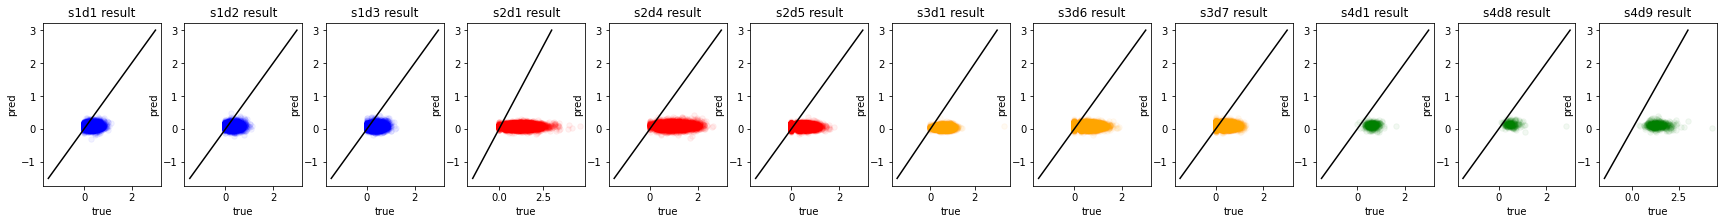

Epoch  100 s1d1:  0.15997665 s1d2:  0.1727649 s1d3:  0.19787917 s2d1: 1.1075771 s2d4: 0.79398876 s2d5: 0.3659942 s3d1: 0.47240344 s3d6: 0.42955306 s3d7: 0.2760047 s4d1: 0.37036043 s4d8: 0.30892357 s4d9: 1.1292261 test: 0.8067609 calc test: 0.8067608755780633
Epoch  200 s1d1:  0.14917254 s1d2:  0.17302805 s1d3:  0.19721738 s2d1: 1.1064463 s2d4: 0.79442304 s2d5: 0.36410454 s3d1: 0.47155297 s3d6: 0.4299288 s3d7: 0.27582228 s4d1: 0.37143943 s4d8: 0.3076967 s4d9: 1.1284612 test: 0.80633825 calc test: 0.8063381489399636
Epoch  300 s1d1:  0.14046428 s1d2:  0.17333871 s1d3:  0.19734062 s2d1: 1.1060737 s2d4: 0.79559267 s2d5: 0.36338356 s3d1: 0.47114012 s3d6: 0.43048373 s3d7: 0.27621773 s4d1: 0.3729324 s4d8: 0.30819982 s4d9: 1.1296784 test: 0.8073897 calc test: 0.8073896790467668
Epoch  400 s1d1:  0.13264471 s1d2:  0.17387925 s1d3:  0.19733308 s2d1: 1.1050956 s2d4: 0.79542375 s2d5: 0.36230865 s3d1: 0.47046527 s3d6: 0.43012702 s3d7: 0.27609637 s4d1: 0.37262717 s4d8: 0.30758646 s4d9: 1.1291941 tes

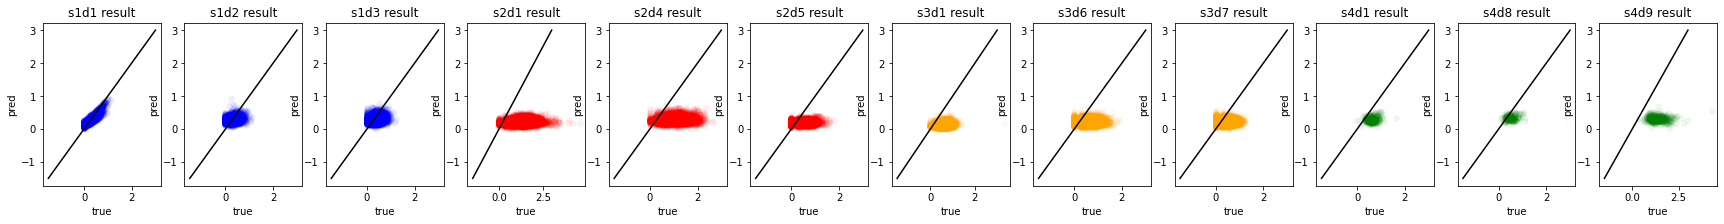

Epoch  1100 s1d1:  0.08945338 s1d2:  0.17867208 s1d3:  0.2011488 s2d1: 1.1041588 s2d4: 0.7969862 s2d5: 0.36231673 s3d1: 0.47055975 s3d6: 0.4308773 s3d7: 0.27848533 s4d1: 0.37491372 s4d8: 0.30702457 s4d9: 1.1278765 test: 0.80644673 calc test: 0.8064466560456052
Epoch  1200 s1d1:  0.084420525 s1d2:  0.17943783 s1d3:  0.20144358 s2d1: 1.1034938 s2d4: 0.7961661 s2d5: 0.36200085 s3d1: 0.4701595 s3d6: 0.4303498 s3d7: 0.27837217 s4d1: 0.3742195 s4d8: 0.30619135 s4d9: 1.1265479 test: 0.80542046 calc test: 0.8054203386956114
Epoch  1300 s1d1:  0.07965643 s1d2:  0.18000479 s1d3:  0.20185187 s2d1: 1.1034534 s2d4: 0.79601383 s2d5: 0.36237377 s3d1: 0.47018123 s3d6: 0.4305125 s3d7: 0.27881312 s4d1: 0.37408352 s4d8: 0.305926 s4d9: 1.1260321 test: 0.8050473 calc test: 0.8050471935734328
Epoch  1400 s1d1:  0.07513859 s1d2:  0.18065685 s1d3:  0.20245361 s2d1: 1.1036083 s2d4: 0.7962634 s2d5: 0.36266905 s3d1: 0.47028586 s3d6: 0.4306461 s3d7: 0.27911082 s4d1: 0.3743127 s4d8: 0.30588016 s4d9: 1.1259171 test

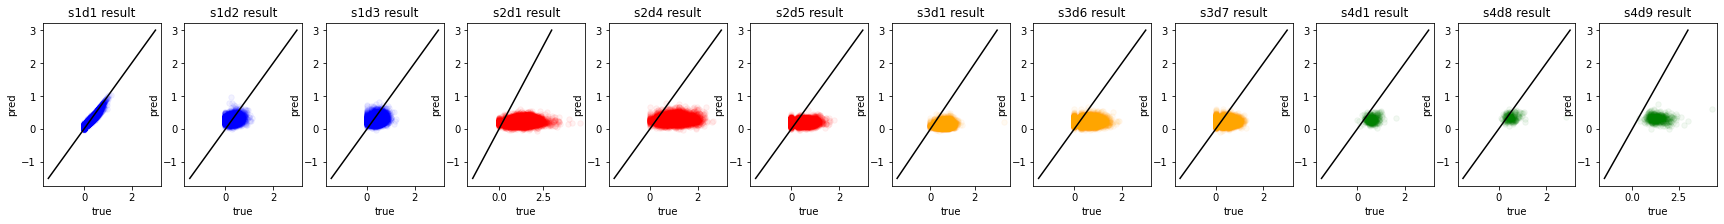

Epoch  2100 s1d1:  0.049983893 s1d2:  0.18416132 s1d3:  0.20508835 s2d1: 1.1034552 s2d4: 0.7961491 s2d5: 0.36380023 s3d1: 0.46932846 s3d6: 0.43074262 s3d7: 0.28028587 s4d1: 0.3742792 s4d8: 0.30504468 s4d9: 1.1244538 test: 0.80399513 calc test: 0.8039950797204517
Epoch  2200 s1d1:  0.04723547 s1d2:  0.18444347 s1d3:  0.20518051 s2d1: 1.1033473 s2d4: 0.7958712 s2d5: 0.36391884 s3d1: 0.4690891 s3d6: 0.43075174 s3d7: 0.28038362 s4d1: 0.37405837 s4d8: 0.3048085 s4d9: 1.1241462 test: 0.8037448 calc test: 0.8037447748025482
Epoch  2300 s1d1:  0.044654563 s1d2:  0.18482353 s1d3:  0.20539063 s2d1: 1.1032678 s2d4: 0.79569566 s2d5: 0.3639243 s3d1: 0.4688857 s3d6: 0.4305813 s3d7: 0.28032872 s4d1: 0.37368262 s4d8: 0.30448112 s4d9: 1.1237515 test: 0.8034073 calc test: 0.8034072866085552
Epoch  2400 s1d1:  0.04226953 s1d2:  0.18514861 s1d3:  0.20557944 s2d1: 1.1029235 s2d4: 0.7955749 s2d5: 0.3637317 s3d1: 0.4684048 s3d6: 0.43028992 s3d7: 0.28017375 s4d1: 0.37347233 s4d8: 0.30437255 s4d9: 1.1234922 te

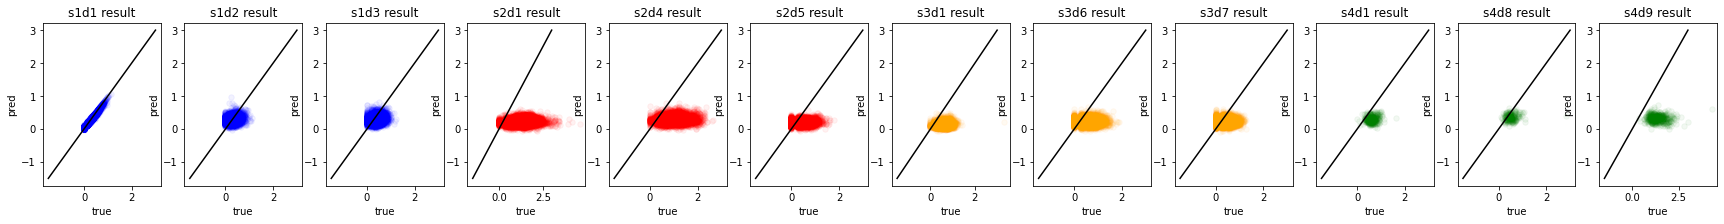

Epoch  3100 s1d1:  0.02936979 s1d2:  0.1864304 s1d3:  0.20657176 s2d1: 1.1027695 s2d4: 0.7952848 s2d5: 0.36388215 s3d1: 0.4667431 s3d6: 0.43007195 s3d7: 0.28029162 s4d1: 0.3731134 s4d8: 0.3040071 s4d9: 1.1229664 test: 0.80277765 calc test: 0.8027776385062769
Epoch  3200 s1d1:  0.027986234 s1d2:  0.18656336 s1d3:  0.20660119 s2d1: 1.1025687 s2d4: 0.7950048 s2d5: 0.36376077 s3d1: 0.46647 s3d6: 0.42983532 s3d7: 0.28014073 s4d1: 0.37281403 s4d8: 0.30380705 s4d9: 1.1225882 test: 0.8024727 calc test: 0.8024726296104949
Epoch  3300 s1d1:  0.026726648 s1d2:  0.18660928 s1d3:  0.2069028 s2d1: 1.1030722 s2d4: 0.7955251 s2d5: 0.36428738 s3d1: 0.46662846 s3d6: 0.43027106 s3d7: 0.28047737 s4d1: 0.37344703 s4d8: 0.30422667 s4d9: 1.1233633 test: 0.80310154 calc test: 0.8031014528375676
Epoch  3400 s1d1:  0.025500603 s1d2:  0.18673523 s1d3:  0.2067204 s2d1: 1.102618 s2d4: 0.79482543 s2d5: 0.36383718 s3d1: 0.4660799 s3d6: 0.42980295 s3d7: 0.28015962 s4d1: 0.37262234 s4d8: 0.30365363 s4d9: 1.1224344 tes

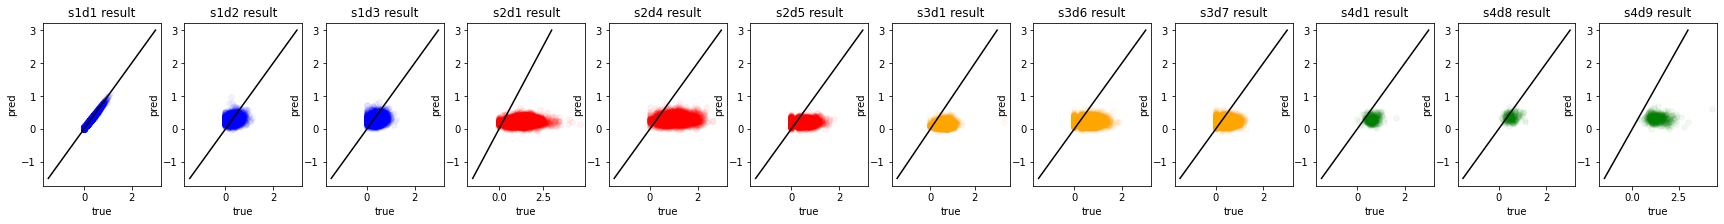

Epoch  4100 s1d1:  0.0191245 s1d2:  0.18700124 s1d3:  0.20660931 s2d1: 1.1017561 s2d4: 0.793801 s2d5: 0.36302224 s3d1: 0.46435195 s3d6: 0.4289603 s3d7: 0.27973858 s4d1: 0.37111753 s4d8: 0.30256253 s4d9: 1.1208407 test: 0.8009901 calc test: 0.8009900747534736
Epoch  4200 s1d1:  0.018430905 s1d2:  0.18694735 s1d3:  0.20672251 s2d1: 1.1021212 s2d4: 0.7941555 s2d5: 0.36335775 s3d1: 0.46440277 s3d6: 0.42924166 s3d7: 0.27990147 s4d1: 0.37157416 s4d8: 0.3028923 s4d9: 1.1214633 test: 0.80148655 calc test: 0.8014864609764895
Epoch  4300 s1d1:  0.01776451 s1d2:  0.18705189 s1d3:  0.20664974 s2d1: 1.101821 s2d4: 0.79379153 s2d5: 0.36298832 s3d1: 0.46400404 s3d6: 0.4289036 s3d7: 0.27959663 s4d1: 0.37129506 s4d8: 0.30280355 s4d9: 1.1212245 test: 0.80128294 calc test: 0.8012829592530962
Epoch  4400 s1d1:  0.017169131 s1d2:  0.18694119 s1d3:  0.2067576 s2d1: 1.1020312 s2d4: 0.79394454 s2d5: 0.36316913 s3d1: 0.46387157 s3d6: 0.42909193 s3d7: 0.27974853 s4d1: 0.37167478 s4d8: 0.30300418 s4d9: 1.1216961

In [35]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s1d1, pro_s1d1)

Epoch  0 s1d1:  0.27876395 s1d2:  0.25994426 s1d3:  0.3221365 s2d1: 1.2223686 s2d4: 0.95147777 s2d5: 0.4407874 s3d1: 0.5422574 s3d6: 0.51710147 s3d7: 0.33579424 s4d1: 0.5243195 s4d8: 0.44712844 s4d9: 1.2965351 test: 0.951202 calc test: 0.9512018841938512


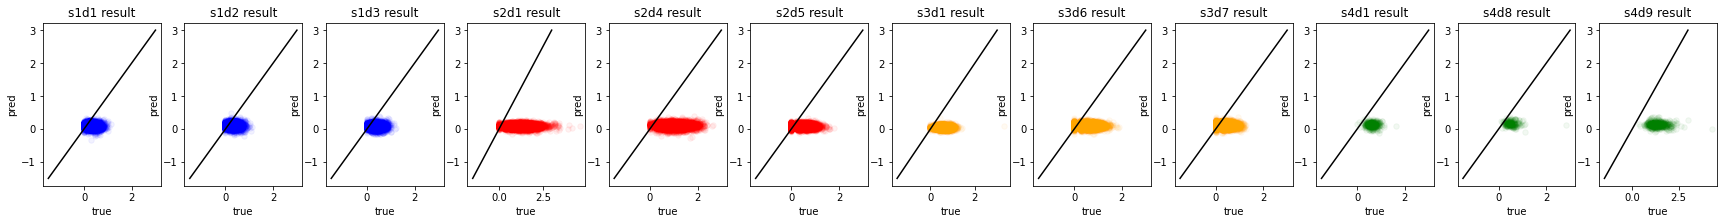

Epoch  100 s1d1:  0.17828725 s1d2:  0.15647815 s1d3:  0.19451664 s2d1: 1.0931355 s2d4: 0.7911906 s2d5: 0.3594133 s3d1: 0.45893508 s3d6: 0.42284554 s3d7: 0.27598622 s4d1: 0.3648951 s4d8: 0.31171298 s4d9: 1.1239611 test: 0.80276656 calc test: 0.8027665587468304
Epoch  200 s1d1:  0.17858006 s1d2:  0.14663526 s1d3:  0.19402051 s2d1: 1.0899438 s2d4: 0.79162806 s2d5: 0.35681877 s3d1: 0.45533347 s3d6: 0.4224324 s3d7: 0.27538106 s4d1: 0.3630972 s4d8: 0.30976677 s4d9: 1.1226321 test: 0.8014838 calc test: 0.8014837666050099
Epoch  300 s1d1:  0.17909543 s1d2:  0.13864332 s1d3:  0.19394943 s2d1: 1.0875044 s2d4: 0.7918531 s2d5: 0.35530758 s3d1: 0.45270672 s3d6: 0.42196733 s3d7: 0.27493417 s4d1: 0.36166492 s4d8: 0.3089897 s4d9: 1.1220245 test: 0.8008147 calc test: 0.8008145661983139
Epoch  400 s1d1:  0.17981343 s1d2:  0.13145371 s1d3:  0.194022 s2d1: 1.0850205 s2d4: 0.7915802 s2d5: 0.35407504 s3d1: 0.45060295 s3d6: 0.42128626 s3d7: 0.27453834 s4d1: 0.36032116 s4d8: 0.3074715 s4d9: 1.1208826 test: 0.

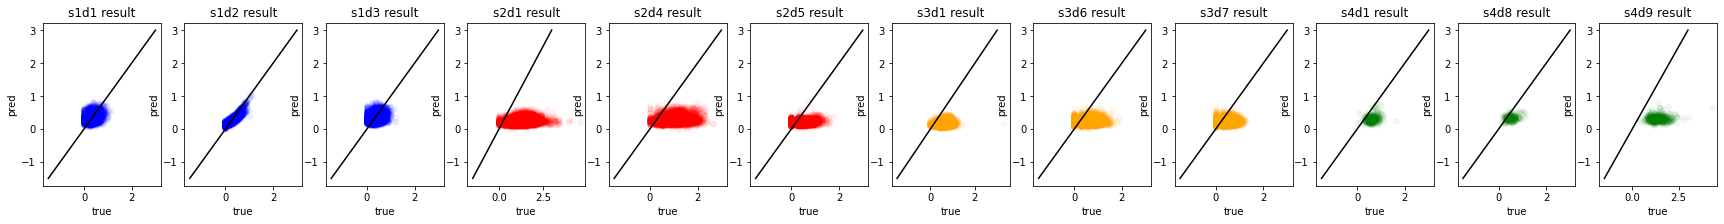

Epoch  1100 s1d1:  0.18512918 s1d2:  0.08781393 s1d3:  0.19693281 s2d1: 1.078849 s2d4: 0.79187393 s2d5: 0.35321683 s3d1: 0.44570315 s3d6: 0.41969752 s3d7: 0.27449363 s4d1: 0.35681778 s4d8: 0.30150163 s4d9: 1.1174035 test: 0.79652023 calc test: 0.7965202910990791
Epoch  1200 s1d1:  0.18557224 s1d2:  0.0823447 s1d3:  0.19731773 s2d1: 1.0790046 s2d4: 0.79235697 s2d5: 0.35358304 s3d1: 0.44576555 s3d6: 0.41976222 s3d7: 0.2746422 s4d1: 0.35670477 s4d8: 0.30090895 s4d9: 1.117101 test: 0.7962622 calc test: 0.796262162277923
Epoch  1300 s1d1:  0.1864424 s1d2:  0.07713403 s1d3:  0.19793682 s2d1: 1.0788643 s2d4: 0.7921057 s2d5: 0.35388792 s3d1: 0.4456599 s3d6: 0.41978416 s3d7: 0.27474102 s4d1: 0.35655534 s4d8: 0.30030054 s4d9: 1.1168898 test: 0.79605633 calc test: 0.7960563153439744
Epoch  1400 s1d1:  0.18713869 s1d2:  0.07217619 s1d3:  0.19843458 s2d1: 1.0790011 s2d4: 0.79203635 s2d5: 0.35431853 s3d1: 0.44574094 s3d6: 0.4198714 s3d7: 0.27489904 s4d1: 0.35638884 s4d8: 0.29973438 s4d9: 1.1165775 t

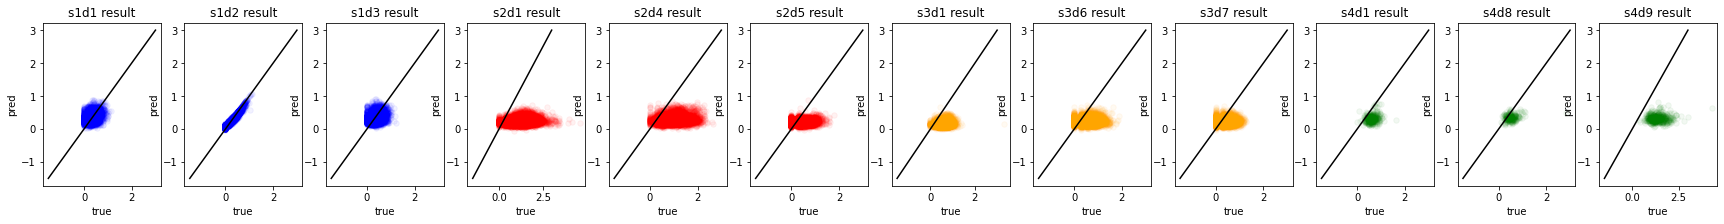

Epoch  2100 s1d1:  0.19020115 s1d2:  0.045330394 s1d3:  0.20077743 s2d1: 1.0805506 s2d4: 0.79233295 s2d5: 0.35698378 s3d1: 0.44642153 s3d6: 0.4207707 s3d7: 0.2758664 s4d1: 0.3562691 s4d8: 0.29746222 s4d9: 1.1154406 test: 0.7948593 calc test: 0.7948593156693485
Epoch  2200 s1d1:  0.1906259 s1d2:  0.0425193 s1d3:  0.20104541 s2d1: 1.0803844 s2d4: 0.7920104 s2d5: 0.3570785 s3d1: 0.4461213 s3d6: 0.4206193 s3d7: 0.2758416 s4d1: 0.35598263 s4d8: 0.29707596 s4d9: 1.1149428 test: 0.79446596 calc test: 0.7944658675247093
Epoch  2300 s1d1:  0.19093166 s1d2:  0.039929505 s1d3:  0.20118889 s2d1: 1.0800155 s2d4: 0.791343 s2d5: 0.35680223 s3d1: 0.44570497 s3d6: 0.42017254 s3d7: 0.27555823 s4d1: 0.3553198 s4d8: 0.29640105 s4d9: 1.1140473 test: 0.79373765 calc test: 0.7937376451610239
Epoch  2400 s1d1:  0.1911108 s1d2:  0.037536215 s1d3:  0.20136419 s2d1: 1.0802804 s2d4: 0.791404 s2d5: 0.35714743 s3d1: 0.4457481 s3d6: 0.42029405 s3d7: 0.27566034 s4d1: 0.35549214 s4d8: 0.29628494 s4d9: 1.1140641 test: 

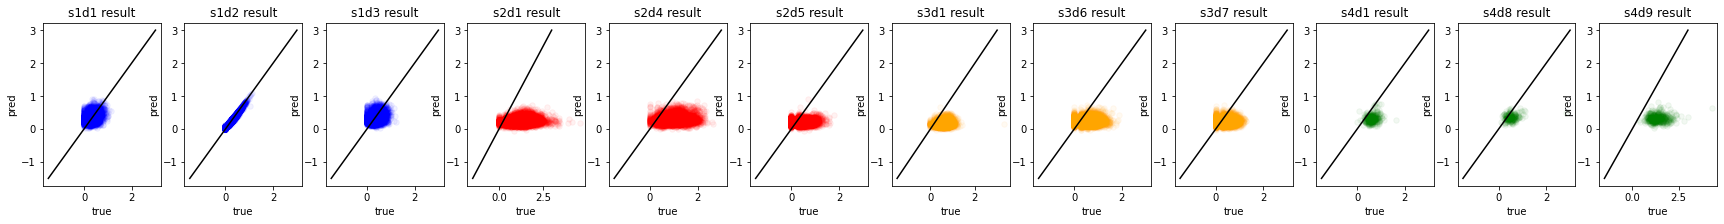

Epoch  3100 s1d1:  0.19174168 s1d2:  0.0254125 s1d3:  0.20203526 s2d1: 1.0809976 s2d4: 0.7915206 s2d5: 0.35803846 s3d1: 0.4454296 s3d6: 0.4207168 s3d7: 0.27601802 s4d1: 0.3558583 s4d8: 0.29587942 s4d9: 1.1141983 test: 0.7938752 calc test: 0.7938752268863852
Epoch  3200 s1d1:  0.191539 s1d2:  0.024185667 s1d3:  0.2018045 s2d1: 1.0805799 s2d4: 0.7909465 s2d5: 0.35775572 s3d1: 0.4451244 s3d6: 0.4202333 s3d7: 0.2757218 s4d1: 0.35506156 s4d8: 0.29514924 s4d9: 1.1132165 test: 0.79306716 calc test: 0.793067193338008
Epoch  3300 s1d1:  0.19188394 s1d2:  0.023014938 s1d3:  0.20185605 s2d1: 1.0800252 s2d4: 0.79026353 s2d5: 0.35752583 s3d1: 0.4445936 s3d6: 0.41985813 s3d7: 0.27557638 s4d1: 0.35436022 s4d8: 0.29453915 s4d9: 1.1121782 test: 0.7922464 calc test: 0.7922463888320089
Epoch  3400 s1d1:  0.19180033 s1d2:  0.021959195 s1d3:  0.2018211 s2d1: 1.0801551 s2d4: 0.7903845 s2d5: 0.35751277 s3d1: 0.44450957 s3d6: 0.41981882 s3d7: 0.27549255 s4d1: 0.3544675 s4d8: 0.2946391 s4d9: 1.1124543 test: 0.

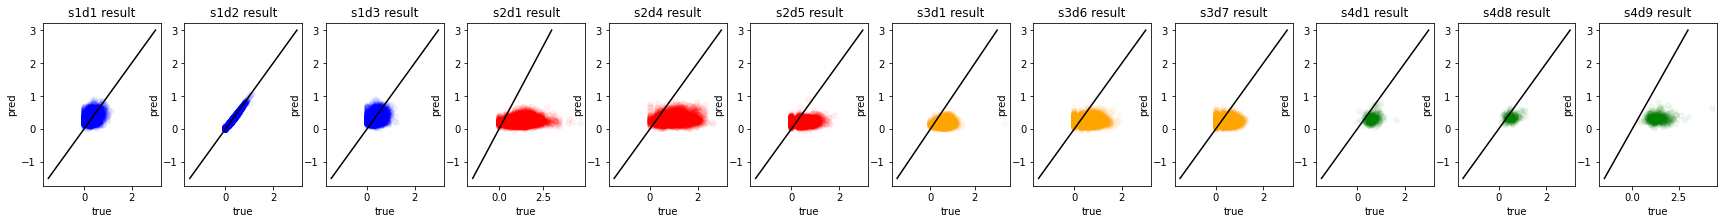

Epoch  4100 s1d1:  0.19188881 s1d2:  0.016362222 s1d3:  0.20188957 s2d1: 1.080054 s2d4: 0.7897469 s2d5: 0.35746604 s3d1: 0.44353208 s3d6: 0.41953704 s3d7: 0.27543518 s4d1: 0.35395733 s4d8: 0.29403836 s4d9: 1.1117601 test: 0.7918783 calc test: 0.7918782847962224
Epoch  4200 s1d1:  0.19162813 s1d2:  0.01579452 s1d3:  0.20178656 s2d1: 1.0802073 s2d4: 0.7900716 s2d5: 0.35740438 s3d1: 0.44347456 s3d6: 0.41955099 s3d7: 0.2754182 s4d1: 0.35404757 s4d8: 0.2941214 s4d9: 1.1118176 test: 0.7919352 calc test: 0.791935179553073
Epoch  4300 s1d1:  0.19193032 s1d2:  0.015201889 s1d3:  0.20201606 s2d1: 1.0801302 s2d4: 0.78988135 s2d5: 0.3574191 s3d1: 0.44322217 s3d6: 0.41960332 s3d7: 0.27546173 s4d1: 0.3542613 s4d8: 0.29428607 s4d9: 1.1121043 test: 0.79216444 calc test: 0.7921645223842192
Epoch  4400 s1d1:  0.19179201 s1d2:  0.014729407 s1d3:  0.2017776 s2d1: 1.0799029 s2d4: 0.7894986 s2d5: 0.357178 s3d1: 0.4430172 s3d6: 0.4193393 s3d7: 0.2752735 s4d1: 0.3535567 s4d8: 0.29380718 s4d9: 1.1113256 test: 

In [36]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s1d2, pro_s1d2)

Epoch  0 s1d1:  0.26782748 s1d2:  0.25614056 s1d3:  0.30965316 s2d1: 1.2153027 s2d4: 0.9424566 s2d5: 0.43973252 s3d1: 0.5373762 s3d6: 0.5137263 s3d7: 0.33488828 s4d1: 0.51879424 s4d8: 0.44455543 s4d9: 1.2914526 test: 0.9467564 calc test: 0.9467563918315095


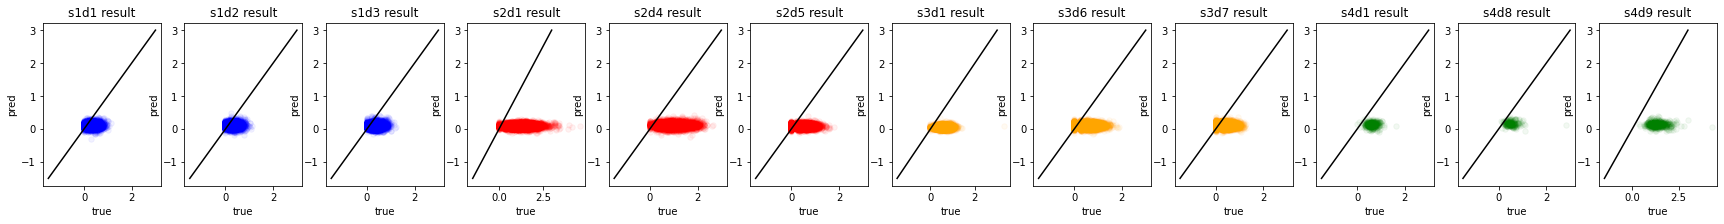

Epoch  100 s1d1:  0.1866589 s1d2:  0.18366896 s1d3:  0.1731076 s2d1: 1.056979 s2d4: 0.74274266 s2d5: 0.3403756 s3d1: 0.4373026 s3d6: 0.3920123 s3d7: 0.25995776 s4d1: 0.31463587 s4d8: 0.26874793 s4d9: 1.0489794 test: 0.7436931 calc test: 0.7436931206337065
Epoch  200 s1d1:  0.18600819 s1d2:  0.18265973 s1d3:  0.16396934 s2d1: 1.0582141 s2d4: 0.7445753 s2d5: 0.34119865 s3d1: 0.4367799 s3d6: 0.3939337 s3d7: 0.2611365 s4d1: 0.31820038 s4d8: 0.26888505 s4d9: 1.0488286 test: 0.74411225 calc test: 0.7441121694676036
Epoch  300 s1d1:  0.18633634 s1d2:  0.18248734 s1d3:  0.15657915 s2d1: 1.0576357 s2d4: 0.7444603 s2d5: 0.3410524 s3d1: 0.43552324 s3d6: 0.39438805 s3d7: 0.26163122 s4d1: 0.31872678 s4d8: 0.26846486 s4d9: 1.0474776 test: 0.7432821 calc test: 0.743282081536579
Epoch  400 s1d1:  0.18671885 s1d2:  0.18257374 s1d3:  0.14988706 s2d1: 1.0571046 s2d4: 0.7448643 s2d5: 0.34085014 s3d1: 0.43452606 s3d6: 0.39459312 s3d7: 0.2619108 s4d1: 0.31932032 s4d8: 0.26839694 s4d9: 1.0467383 test: 0.7428

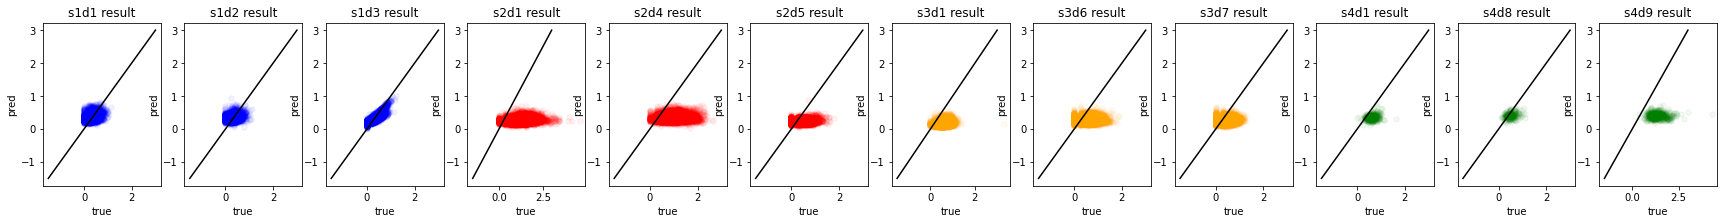

Epoch  1100 s1d1:  0.19243118 s1d2:  0.18755373 s1d3:  0.11060956 s2d1: 1.0549607 s2d4: 0.74447876 s2d5: 0.3405677 s3d1: 0.43107283 s3d6: 0.394241 s3d7: 0.26367024 s4d1: 0.31689137 s4d8: 0.2667541 s4d9: 1.0395634 test: 0.7377721 calc test: 0.7377720734409995
Epoch  1200 s1d1:  0.19345514 s1d2:  0.18877429 s1d3:  0.10569929 s2d1: 1.0542727 s2d4: 0.7437603 s2d5: 0.34037775 s3d1: 0.43051767 s3d6: 0.39373648 s3d7: 0.2637241 s4d1: 0.3159338 s4d8: 0.2663074 s4d9: 1.0378872 test: 0.73651725 calc test: 0.7365172147677654
Epoch  1300 s1d1:  0.19396736 s1d2:  0.18919134 s1d3:  0.10096551 s2d1: 1.0549427 s2d4: 0.74437183 s2d5: 0.3410203 s3d1: 0.43076596 s3d6: 0.3942508 s3d7: 0.26429373 s4d1: 0.3165672 s4d8: 0.26673973 s4d9: 1.0384147 test: 0.7369815 calc test: 0.7369815891122713
Epoch  1400 s1d1:  0.195331 s1d2:  0.19061998 s1d3:  0.09637111 s2d1: 1.0536561 s2d4: 0.74258214 s2d5: 0.34055004 s3d1: 0.42983666 s3d6: 0.39333537 s3d7: 0.26414436 s4d1: 0.31487495 s4d8: 0.26590034 s4d9: 1.0358695 test: 

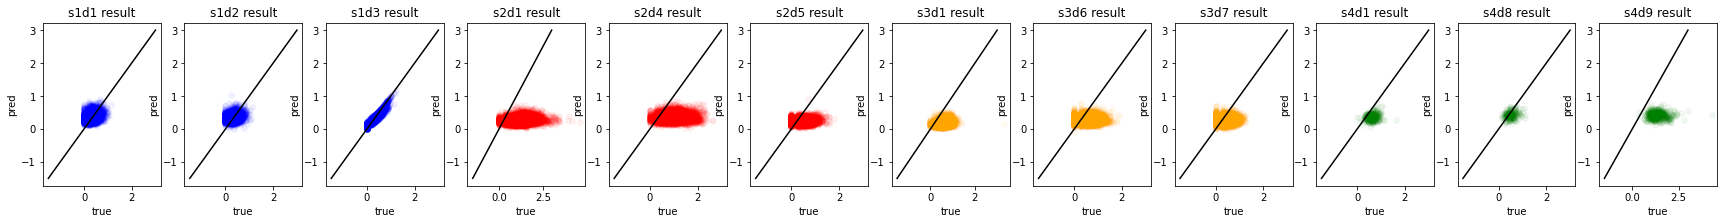

Epoch  2100 s1d1:  0.20030801 s1d2:  0.19647042 s1d3:  0.06873641 s2d1: 1.0523984 s2d4: 0.73982066 s2d5: 0.34107074 s3d1: 0.428191 s3d6: 0.39245874 s3d7: 0.26562396 s4d1: 0.31290558 s4d8: 0.26625088 s4d9: 1.0300802 test: 0.7310301 calc test: 0.7310300725247323
Epoch  2200 s1d1:  0.2009038 s1d2:  0.19707216 s1d3:  0.06541527 s2d1: 1.0522393 s2d4: 0.739393 s2d5: 0.34116524 s3d1: 0.4279103 s3d6: 0.39242977 s3d7: 0.2658147 s4d1: 0.31285968 s4d8: 0.26629534 s4d9: 1.0295675 test: 0.7306953 calc test: 0.7306952794250416
Epoch  2300 s1d1:  0.20137177 s1d2:  0.1975647 s1d3:  0.06226844 s2d1: 1.0523366 s2d4: 0.73919356 s2d5: 0.34132555 s3d1: 0.42778555 s3d6: 0.39251664 s3d7: 0.26605174 s4d1: 0.3130814 s4d8: 0.26659253 s4d9: 1.0296433 test: 0.7307985 calc test: 0.7307984360755309
Epoch  2400 s1d1:  0.20243178 s1d2:  0.19879887 s1d3:  0.05925717 s2d1: 1.0511843 s2d4: 0.73761463 s2d5: 0.34079808 s3d1: 0.4270175 s3d6: 0.39176536 s3d7: 0.26592827 s4d1: 0.31168047 s4d8: 0.266141 s4d9: 1.0273978 test: 

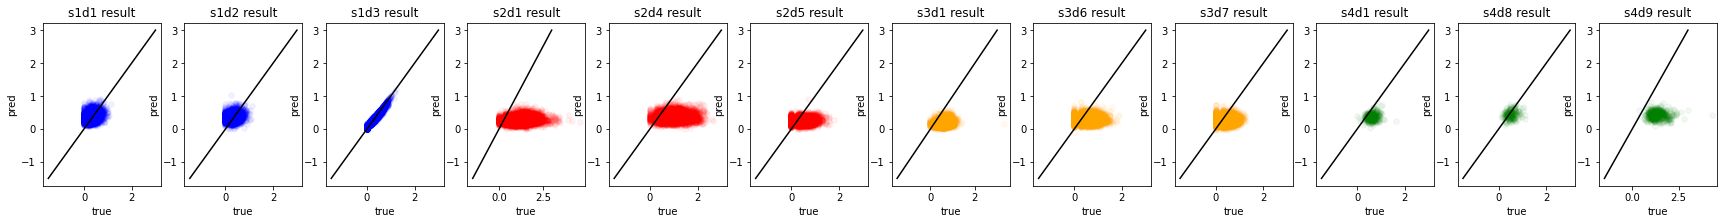

Epoch  3100 s1d1:  0.20534535 s1d2:  0.20225723 s1d3:  0.0422495 s2d1: 1.0501244 s2d4: 0.73466 s2d5: 0.34081075 s3d1: 0.4256491 s3d6: 0.39124256 s3d7: 0.2667003 s4d1: 0.31005198 s4d8: 0.26700717 s4d9: 1.0237347 test: 0.7265761 calc test: 0.7265760917007558
Epoch  3200 s1d1:  0.20511998 s1d2:  0.2020399 s1d3:  0.040350746 s2d1: 1.0511435 s2d4: 0.7356596 s2d5: 0.3413784 s3d1: 0.42612842 s3d6: 0.39194015 s3d7: 0.26709607 s4d1: 0.31129277 s4d8: 0.26774043 s4d9: 1.0252573 test: 0.72779363 calc test: 0.7277935725525589
Epoch  3300 s1d1:  0.20554481 s1d2:  0.20261465 s1d3:  0.038543988 s2d1: 1.05051 s2d4: 0.73479986 s2d5: 0.34107527 s3d1: 0.42562604 s3d6: 0.39149818 s3d7: 0.26700896 s4d1: 0.3104779 s4d8: 0.267583 s4d9: 1.0239968 test: 0.7268502 calc test: 0.7268501972682322
Epoch  3400 s1d1:  0.20622034 s1d2:  0.20325457 s1d3:  0.03678521 s2d1: 1.0497826 s2d4: 0.73366374 s2d5: 0.3407469 s3d1: 0.42511424 s3d6: 0.39106268 s3d7: 0.26690596 s4d1: 0.3098296 s4d8: 0.26742423 s4d9: 1.0229592 test: 0

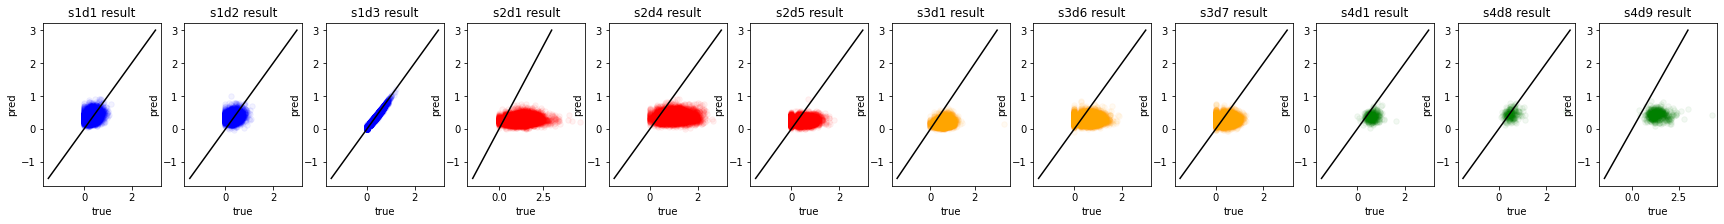

Epoch  4100 s1d1:  0.20671676 s1d2:  0.20412129 s1d3:  0.02733557 s2d1: 1.050494 s2d4: 0.7335282 s2d5: 0.34110627 s3d1: 0.42475957 s3d6: 0.39152402 s3d7: 0.26748282 s4d1: 0.3102166 s4d8: 0.26839733 s4d9: 1.023101 test: 0.72629577 calc test: 0.7262958196652823
Epoch  4200 s1d1:  0.20695531 s1d2:  0.20453753 s1d3:  0.026239747 s2d1: 1.0500444 s2d4: 0.73281884 s2d5: 0.34084296 s3d1: 0.42440018 s3d6: 0.39110845 s3d7: 0.26735482 s4d1: 0.30947524 s4d8: 0.26827395 s4d9: 1.0219834 test: 0.725458 calc test: 0.72545804440201
Epoch  4300 s1d1:  0.20716476 s1d2:  0.20453395 s1d3:  0.025224771 s2d1: 1.0500079 s2d4: 0.73262054 s2d5: 0.3408996 s3d1: 0.424154 s3d6: 0.39117086 s3d7: 0.26742125 s4d1: 0.3094943 s4d8: 0.2682563 s4d9: 1.0221332 test: 0.7255564 calc test: 0.7255562834398204
Epoch  4400 s1d1:  0.20746014 s1d2:  0.20495458 s1d3:  0.024257885 s2d1: 1.0496236 s2d4: 0.7318521 s2d5: 0.34066465 s3d1: 0.42387974 s3d6: 0.39080366 s3d7: 0.26729926 s4d1: 0.30863413 s4d8: 0.2680196 s4d9: 1.021067 test:

In [37]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s1d3, pro_s1d3)

Epoch  0 s1d1:  0.20801786 s1d2:  0.20696889 s1d3:  0.20939809 s2d1: 1.0542642 s2d4: 0.75987744 s2d5: 0.32968214 s3d1: 0.4378842 s3d6: 0.382757 s3d7: 0.25816256 s4d1: 0.32329398 s4d8: 0.29041442 s4d9: 1.0602376 test: 0.7538776 calc test: 0.7538776620326642


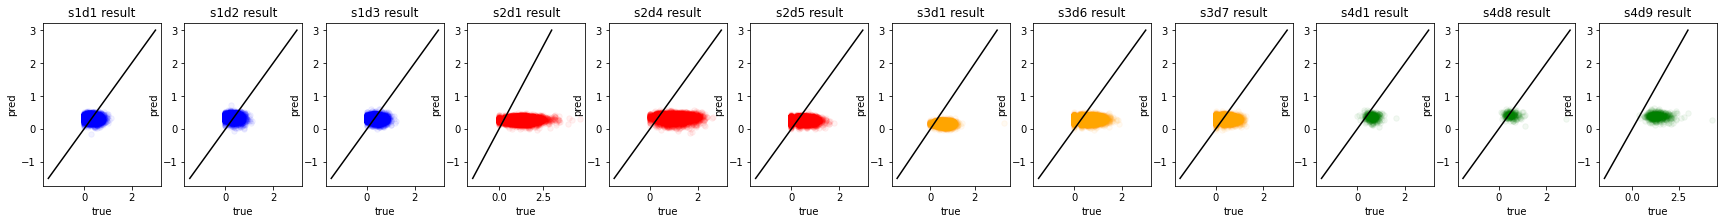

Epoch  100 s1d1:  1.3264035 s1d2:  1.320221 s1d3:  1.2509961 s2d1: 0.49217921 s2d4: 0.7620075 s2d5: 0.7841074 s3d1: 0.30324838 s3d6: 0.78823847 s3d7: 0.90159065 s4d1: 0.9843907 s4d8: 1.1770183 s4d9: 0.5058845 test: 0.8531664 calc test: 0.8531666084944255
Epoch  200 s1d1:  1.3080144 s1d2:  1.31407 s1d3:  1.2292769 s2d1: 0.48394683 s2d4: 0.7456579 s2d5: 0.78566074 s3d1: 0.30904236 s3d6: 0.78423464 s3d7: 0.8915734 s4d1: 0.9743021 s4d8: 1.181422 s4d9: 0.500498 test: 0.8490904 calc test: 0.849090660528191
Epoch  300 s1d1:  1.29593 s1d2:  1.3035756 s1d3:  1.2161252 s2d1: 0.47570258 s2d4: 0.7377728 s2d5: 0.78464943 s3d1: 0.31710544 s3d6: 0.7818034 s3d7: 0.88746506 s4d1: 0.96758556 s4d8: 1.1806796 s4d9: 0.49547863 test: 0.8449501 calc test: 0.8449503203112921
Epoch  400 s1d1:  1.287078 s1d2:  1.2920307 s1d3:  1.2054791 s2d1: 0.46620798 s2d4: 0.7331065 s2d5: 0.78227764 s3d1: 0.32529786 s3d6: 0.7793082 s3d7: 0.8863612 s4d1: 0.9623405 s4d8: 1.1788303 s4d9: 0.49014962 test: 0.840979 calc test: 0.8

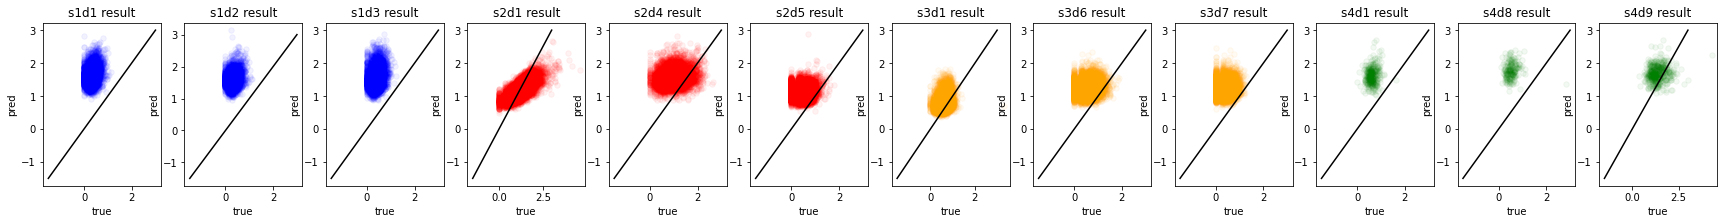

Epoch  1100 s1d1:  1.3570138 s1d2:  1.3528081 s1d3:  1.2364249 s2d1: 0.35606825 s2d4: 0.82247096 s2d5: 0.7992257 s3d1: 0.3522989 s3d6: 0.82500726 s3d7: 0.959507 s4d1: 1.0733364 s4d8: 1.3293618 s4d9: 0.5726112 test: 0.9492596 calc test: 0.9492600084921994
Epoch  1200 s1d1:  1.372543 s1d2:  1.370221 s1d3:  1.2471651 s2d1: 0.33670333 s2d4: 0.8421804 s2d5: 0.80474406 s3d1: 0.35247016 s3d6: 0.8368199 s3d7: 0.97112936 s4d1: 1.0955253 s4d8: 1.357485 s4d9: 0.59512717 test: 0.972048 calc test: 0.9720484059727935
Epoch  1300 s1d1:  1.3854599 s1d2:  1.3849322 s1d3:  1.2558392 s2d1: 0.3175045 s2d4: 0.8600745 s2d5: 0.8083371 s3d1: 0.3520529 s3d6: 0.8470236 s3d7: 0.98093295 s4d1: 1.1150082 s4d8: 1.3817849 s4d9: 0.61602026 test: 0.99229807 calc test: 0.9922984670026525
Epoch  1400 s1d1:  1.4032149 s1d2:  1.4059429 s1d3:  1.2698752 s2d1: 0.29865047 s2d4: 0.8812192 s2d5: 0.816707 s3d1: 0.35302496 s3d6: 0.8611238 s3d7: 0.9947127 s4d1: 1.1396849 s4d8: 1.412071 s4d9: 0.64050424 test: 1.017288 calc test: 1

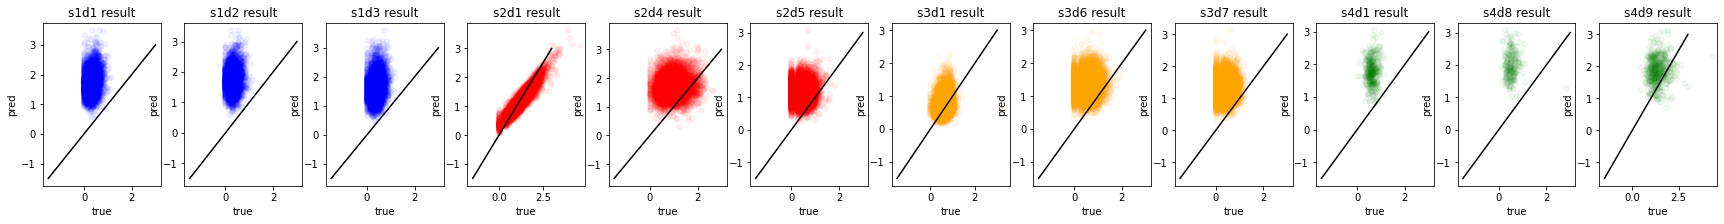

Epoch  2100 s1d1:  1.5077065 s1d2:  1.5276968 s1d3:  1.3516177 s2d1: 0.18683694 s2d4: 0.99961233 s2d5: 0.8499476 s3d1: 0.35811812 s3d6: 0.92955154 s3d7: 1.0651187 s4d1: 1.27562 s4d8: 1.5841632 s4d9: 0.7831019 test: 1.1595036 calc test: 1.1595040411481885
Epoch  2200 s1d1:  1.5169246 s1d2:  1.5392143 s1d3:  1.3573232 s2d1: 0.17410861 s2d4: 1.0102223 s2d5: 0.8508133 s3d1: 0.35781848 s3d6: 0.93370664 s3d7: 1.0710728 s4d1: 1.2877349 s4d8: 1.6007053 s4d9: 0.79589814 test: 1.1726042 calc test: 1.1726046940845067
Epoch  2300 s1d1:  1.5271107 s1d2:  1.550807 s1d3:  1.3653193 s2d1: 0.16222446 s2d4: 1.0206047 s2d5: 0.85258204 s3d1: 0.3584582 s3d6: 0.9382288 s3d7: 1.0765607 s4d1: 1.2997543 s4d8: 1.6166222 s4d9: 0.80954367 test: 1.1857673 calc test: 1.1857677003430904
Epoch  2400 s1d1:  1.533853 s1d2:  1.560903 s1d3:  1.3689268 s2d1: 0.15122946 s2d4: 1.028825 s2d5: 0.85369056 s3d1: 0.3574373 s3d6: 0.94214123 s3d7: 1.0813179 s4d1: 1.311095 s4d8: 1.6330442 s4d9: 0.82192147 test: 1.1984363 calc test:

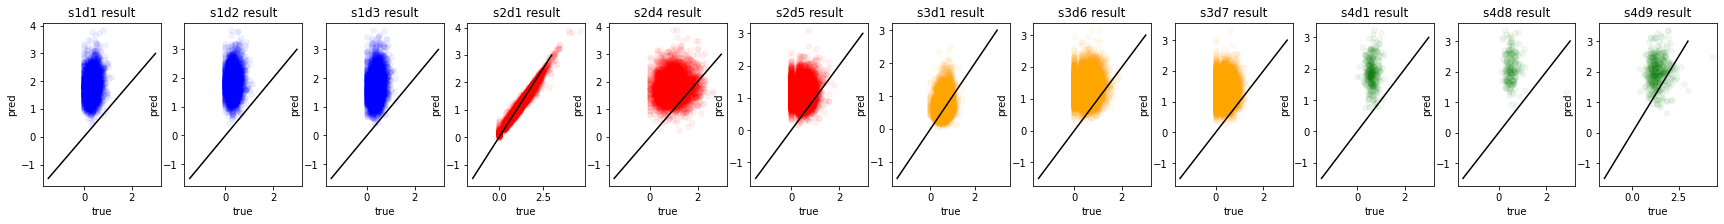

Epoch  3100 s1d1:  1.586725 s1d2:  1.6242934 s1d3:  1.4073596 s2d1: 0.093406625 s2d4: 1.0858493 s2d5: 0.8639958 s3d1: 0.3594318 s3d6: 0.9689536 s3d7: 1.1143488 s4d1: 1.3778121 s4d8: 1.7225072 s4d9: 0.8896356 test: 1.2694507 calc test: 1.269451088660426
Epoch  3200 s1d1:  1.5849001 s1d2:  1.6227463 s1d3:  1.4041016 s2d1: 0.08763816 s2d4: 1.0852628 s2d5: 0.8596229 s3d1: 0.35793844 s3d6: 0.9656111 s3d7: 1.1115046 s4d1: 1.3773395 s4d8: 1.7236654 s4d9: 0.8906394 test: 1.2699277 calc test: 1.2699281650459013
Epoch  3300 s1d1:  1.5939965 s1d2:  1.6348418 s1d3:  1.4110485 s2d1: 0.08201028 s2d4: 1.094197 s2d5: 0.8648019 s3d1: 0.35865158 s3d6: 0.9719107 s3d7: 1.118645 s4d1: 1.3889716 s4d8: 1.7387184 s4d9: 0.9019499 test: 1.2820135 calc test: 1.2820139939461992
Epoch  3400 s1d1:  1.5943437 s1d2:  1.6350939 s1d3:  1.4111648 s2d1: 0.0770157 s2d4: 1.0958095 s2d5: 0.8631332 s3d1: 0.3584307 s3d6: 0.97137237 s3d7: 1.118202 s4d1: 1.3900144 s4d8: 1.7403876 s4d9: 0.90410435 test: 1.2835556 calc test: 1.28

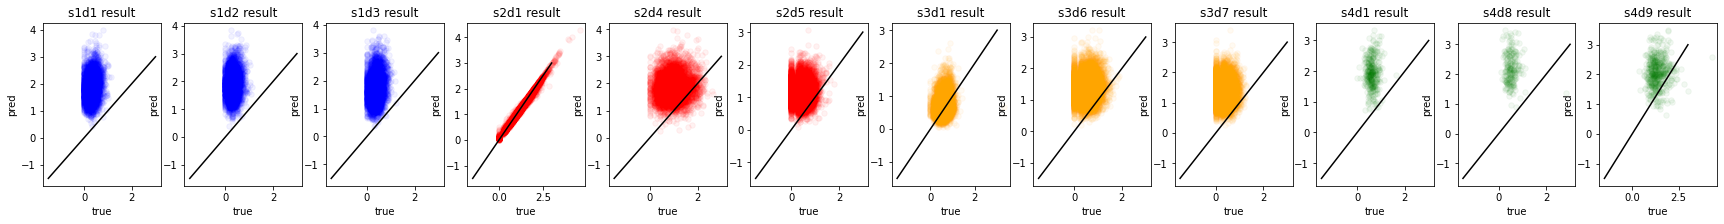

Epoch  4100 s1d1:  1.621968 s1d2:  1.6671546 s1d3:  1.4301388 s2d1: 0.05127991 s2d4: 1.1274219 s2d5: 0.8703051 s3d1: 0.3600839 s3d6: 0.9870422 s3d7: 1.1356318 s4d1: 1.428298 s4d8: 1.7895365 s4d9: 0.9415707 test: 1.323331 calc test: 1.323331372780973
Epoch  4200 s1d1:  1.6199994 s1d2:  1.6666687 s1d3:  1.4267955 s2d1: 0.048553687 s2d4: 1.1265258 s2d5: 0.86913157 s3d1: 0.35936284 s3d6: 0.9858383 s3d7: 1.136504 s4d1: 1.4277939 s4d8: 1.7895975 s4d9: 0.9405436 test: 1.3228309 calc test: 1.3228313991396035
Epoch  4300 s1d1:  1.6274252 s1d2:  1.6739832 s1d3:  1.4330646 s2d1: 0.046256337 s2d4: 1.1332109 s2d5: 0.87195116 s3d1: 0.3608025 s3d6: 0.990028 s3d7: 1.1403602 s4d1: 1.4357158 s4d8: 1.7987376 s4d9: 0.9479318 test: 1.3306583 calc test: 1.3306588218918358
Epoch  4400 s1d1:  1.6288927 s1d2:  1.6756774 s1d3:  1.4339006 s2d1: 0.044119015 s2d4: 1.1358778 s2d5: 0.87218183 s3d1: 0.36055303 s3d6: 0.99172705 s3d7: 1.141856 s4d1: 1.4387858 s4d8: 1.8024467 s4d9: 0.95135915 test: 1.3339235 calc test: 

In [35]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s2d1, pro_s2d1)

Epoch  0 s1d1:  0.20910923 s1d2:  0.2155102 s1d3:  0.20360968 s2d1: 1.0469533 s2d4: 0.7335641 s2d5: 0.32552376 s3d1: 0.43493786 s3d6: 0.37532732 s3d7: 0.2573187 s4d1: 0.301943 s4d8: 0.27958593 s4d9: 1.0368118 test: 0.7348787 calc test: 0.7348786995927326


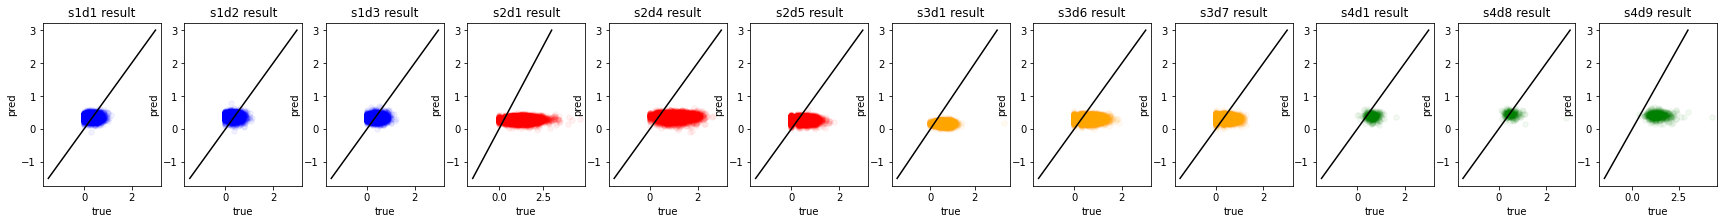

Epoch  100 s1d1:  0.6709744 s1d2:  0.66208893 s1d3:  0.6068243 s2d1: 0.6889178 s2d4: 0.42919326 s2d5: 0.3932672 s3d1: 0.20786814 s3d6: 0.38589838 s3d7: 0.4742109 s4d1: 0.38981393 s4d8: 0.5577406 s4d9: 0.5371023 test: 0.4975511 calc test: 0.4975511792410074
Epoch  200 s1d1:  0.6860699 s1d2:  0.6675661 s1d3:  0.6127166 s2d1: 0.6723542 s2d4: 0.40371448 s2d5: 0.40632436 s3d1: 0.20177984 s3d6: 0.3916866 s3d7: 0.49951154 s4d1: 0.40658483 s4d8: 0.5731675 s4d9: 0.53269887 test: 0.50345534 calc test: 0.5034554025697897
Epoch  300 s1d1:  0.704434 s1d2:  0.67666084 s1d3:  0.6186013 s2d1: 0.6645932 s2d4: 0.3766238 s2d5: 0.41512245 s3d1: 0.20333187 s3d6: 0.3938547 s3d7: 0.51909035 s4d1: 0.4262768 s4d8: 0.59307975 s4d9: 0.53242415 test: 0.51343733 calc test: 0.5134373853559128
Epoch  400 s1d1:  0.7214698 s1d2:  0.68712795 s1d3:  0.6191134 s2d1: 0.6681825 s2d4: 0.3479289 s2d5: 0.41517293 s3d1: 0.20725067 s3d6: 0.39071506 s3d7: 0.52813405 s4d1: 0.44495392 s4d8: 0.6168934 s4d9: 0.53492796 test: 0.52558

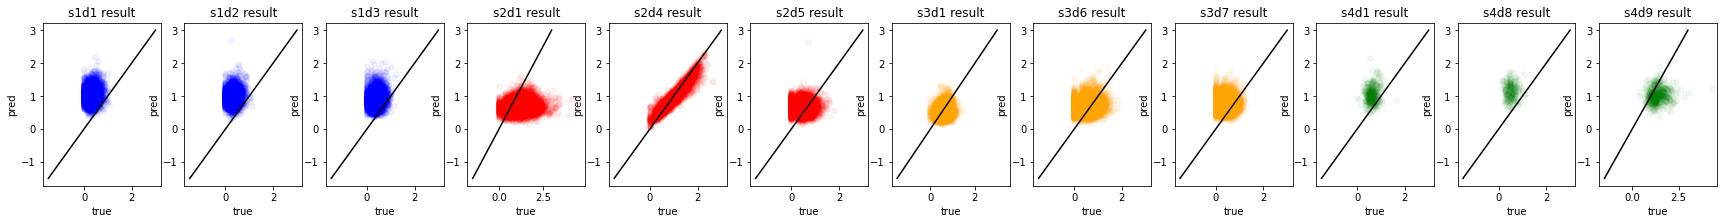

Epoch  1100 s1d1:  0.77029604 s1d2:  0.73266995 s1d3:  0.60727584 s2d1: 0.7228171 s2d4: 0.15275054 s2d5: 0.40719607 s3d1: 0.2377143 s3d6: 0.39221567 s3d7: 0.535064 s4d1: 0.52066183 s4d8: 0.72955894 s4d9: 0.54558015 test: 0.58081454 calc test: 0.5808145733597936
Epoch  1200 s1d1:  0.76665604 s1d2:  0.730188 s1d3:  0.6022481 s2d1: 0.7281714 s2d4: 0.13486174 s2d5: 0.4067888 s3d1: 0.24059755 s3d6: 0.39291602 s3d7: 0.5335167 s4d1: 0.5215755 s4d8: 0.73117393 s4d9: 0.54809135 test: 0.58259124 calc test: 0.5825912571097491
Epoch  1300 s1d1:  0.76184845 s1d2:  0.72610444 s1d3:  0.59622496 s2d1: 0.733148 s2d4: 0.11964023 s2d5: 0.4055625 s3d1: 0.24301188 s3d6: 0.3929352 s3d7: 0.5310799 s4d1: 0.52112675 s4d8: 0.7317826 s4d9: 0.5508736 test: 0.5838185 calc test: 0.5838184902652418
Epoch  1400 s1d1:  0.76310813 s1d2:  0.72863865 s1d3:  0.59527194 s2d1: 0.7349798 s2d4: 0.10627806 s2d5: 0.4068369 s3d1: 0.24466008 s3d6: 0.3950428 s3d7: 0.53415936 s4d1: 0.5258681 s4d8: 0.7394212 s4d9: 0.5496113 test: 0.

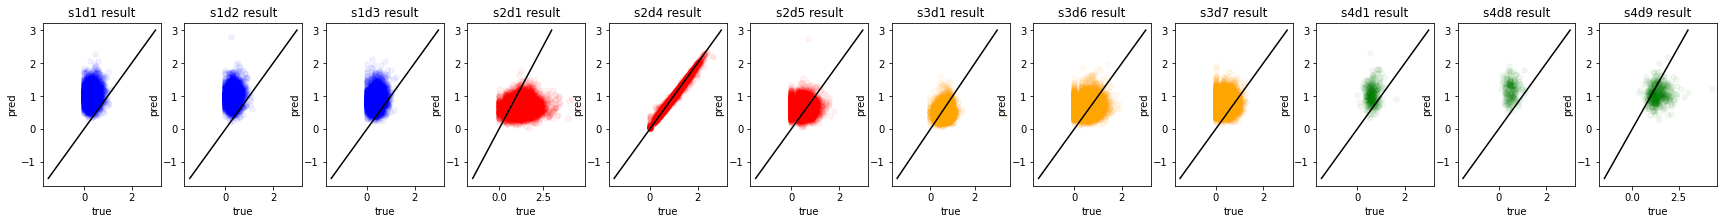

Epoch  2100 s1d1:  0.7566744 s1d2:  0.72820944 s1d3:  0.58323747 s2d1: 0.7472385 s2d4: 0.052378446 s2d5: 0.40456465 s3d1: 0.25119817 s3d6: 0.3966568 s3d7: 0.5341601 s4d1: 0.53126407 s4d8: 0.751903 s4d9: 0.54971457 test: 0.59160906 calc test: 0.5916090065408123
Epoch  2200 s1d1:  0.75952953 s1d2:  0.73249286 s1d3:  0.5849781 s2d1: 0.74623483 s2d4: 0.047821477 s2d5: 0.40604237 s3d1: 0.25111493 s3d6: 0.39812303 s3d7: 0.53764623 s4d1: 0.5354073 s4d8: 0.7577975 s4d9: 0.5474491 test: 0.5934463 calc test: 0.593446297999687
Epoch  2300 s1d1:  0.7612439 s1d2:  0.7340797 s1d3:  0.5854092 s2d1: 0.7455457 s2d4: 0.044014085 s2d5: 0.40635994 s3d1: 0.251257 s3d6: 0.39896536 s3d7: 0.5389973 s4d1: 0.5375905 s4d8: 0.7609703 s4d9: 0.5462585 test: 0.59444153 calc test: 0.594441519468666
Epoch  2400 s1d1:  0.7608397 s1d2:  0.73461795 s1d3:  0.58489144 s2d1: 0.7462656 s2d4: 0.04053808 s2d5: 0.40627337 s3d1: 0.25152418 s3d6: 0.39882115 s3d7: 0.5387186 s4d1: 0.5386923 s4d8: 0.76208913 s4d9: 0.5455363 test: 0.

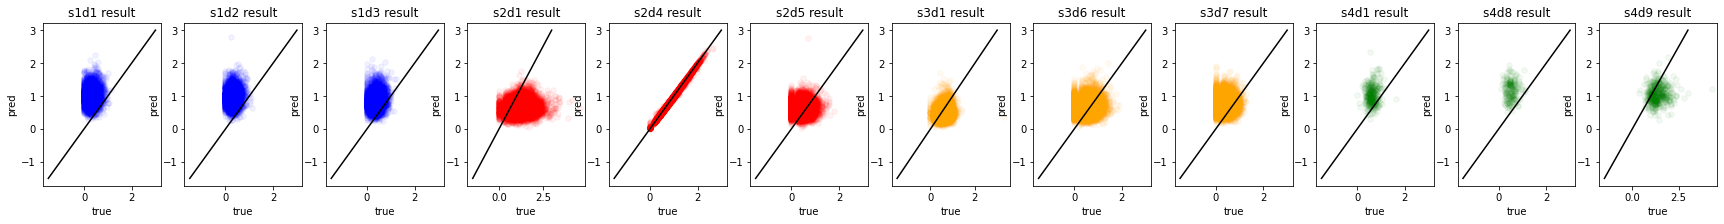

Epoch  3100 s1d1:  0.7570148 s1d2:  0.73387563 s1d3:  0.5794834 s2d1: 0.7478439 s2d4: 0.024898987 s2d5: 0.40557632 s3d1: 0.25235626 s3d6: 0.3988589 s3d7: 0.5394842 s4d1: 0.5390316 s4d8: 0.7655262 s4d9: 0.5446626 test: 0.59541535 calc test: 0.5954153158106028
Epoch  3200 s1d1:  0.7539705 s1d2:  0.73051107 s1d3:  0.5768251 s2d1: 0.7497361 s2d4: 0.023241948 s2d5: 0.4038844 s3d1: 0.25280374 s3d6: 0.39750248 s3d7: 0.53740275 s4d1: 0.5371458 s4d8: 0.7632513 s4d9: 0.5461194 test: 0.5948538 calc test: 0.5948537824890441
Epoch  3300 s1d1:  0.75204027 s1d2:  0.7296105 s1d3:  0.5740227 s2d1: 0.7508845 s2d4: 0.022108382 s2d5: 0.4031009 s3d1: 0.2529287 s3d6: 0.39697587 s3d7: 0.5374619 s4d1: 0.53599244 s4d8: 0.7628573 s4d9: 0.54692173 test: 0.59474003 calc test: 0.594740024182534
Epoch  3400 s1d1:  0.7524619 s1d2:  0.7293683 s1d3:  0.5747951 s2d1: 0.75069684 s2d4: 0.02076623 s2d5: 0.402765 s3d1: 0.25311673 s3d6: 0.39682359 s3d7: 0.53703356 s4d1: 0.53613186 s4d8: 0.76230747 s4d9: 0.54712725 test: 0.5

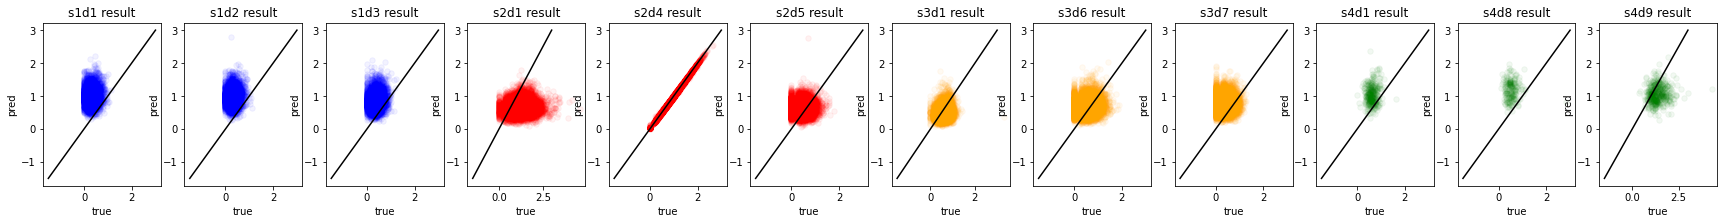

Epoch  4100 s1d1:  0.74753493 s1d2:  0.7266704 s1d3:  0.56974655 s2d1: 0.7517563 s2d4: 0.015442698 s2d5: 0.40168476 s3d1: 0.25285375 s3d6: 0.39586377 s3d7: 0.5355204 s4d1: 0.5344231 s4d8: 0.762173 s4d9: 0.54696184 test: 0.59410334 calc test: 0.5941033158636044
Epoch  4200 s1d1:  0.74503714 s1d2:  0.7242508 s1d3:  0.56763244 s2d1: 0.7530482 s2d4: 0.01539483 s2d5: 0.4004796 s3d1: 0.2530522 s3d6: 0.39507258 s3d7: 0.53425926 s4d1: 0.532218 s4d8: 0.7594161 s4d9: 0.54836136 test: 0.59330297 calc test: 0.5933029896890035
Epoch  4300 s1d1:  0.75224465 s1d2:  0.7324466 s1d3:  0.57405275 s2d1: 0.7491829 s2d4: 0.014458259 s2d5: 0.4038097 s3d1: 0.2521984 s3d6: 0.39785674 s3d7: 0.5393271 s4d1: 0.5400242 s4d8: 0.76920044 s4d9: 0.5433171 test: 0.59613127 calc test: 0.5961312650172153
Epoch  4400 s1d1:  0.7500662 s1d2:  0.73026276 s1d3:  0.57153636 s2d1: 0.7503437 s2d4: 0.013609994 s2d5: 0.40276334 s3d1: 0.2524322 s3d6: 0.39700958 s3d7: 0.53861046 s4d1: 0.53752345 s4d8: 0.766002 s4d9: 0.5452629 test: 

In [36]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s2d4, pro_s2d4)

Epoch  0 s1d1:  0.30063325 s1d2:  0.28117377 s1d3:  0.34412953 s2d1: 1.2344962 s2d4: 0.97262144 s2d5: 0.44912326 s3d1: 0.5482944 s3d6: 0.5289659 s3d7: 0.34503964 s4d1: 0.54775006 s4d8: 0.4702765 s4d9: 1.321203 test: 0.9732473 calc test: 0.9732472313389078


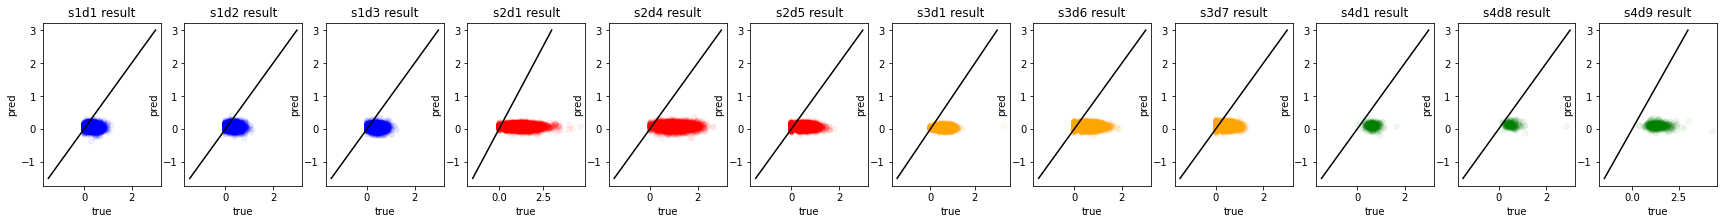

Epoch  100 s1d1:  0.4803109 s1d2:  0.39698446 s1d3:  0.42495635 s2d1: 0.8697012 s2d4: 0.5494616 s2d5: 0.27591646 s3d1: 0.3218083 s3d6: 0.3264874 s3d7: 0.309158 s4d1: 0.24827884 s4d8: 0.2833196 s4d9: 0.84622574 test: 0.60489124 calc test: 0.6048912554673004
Epoch  200 s1d1:  0.49386758 s1d2:  0.4041043 s1d3:  0.4299571 s2d1: 0.86306846 s2d4: 0.54530495 s2d5: 0.26978898 s3d1: 0.3229598 s3d6: 0.32891834 s3d7: 0.30961627 s4d1: 0.24798962 s4d8: 0.28977412 s4d9: 0.84056115 test: 0.6018517 calc test: 0.6018516918536138
Epoch  300 s1d1:  0.5037449 s1d2:  0.40891248 s1d3:  0.43466437 s2d1: 0.8601259 s2d4: 0.54508674 s2d5: 0.2640365 s3d1: 0.3256082 s3d6: 0.33119377 s3d7: 0.30927178 s4d1: 0.24957044 s4d8: 0.2933383 s4d9: 0.8394125 test: 0.60169154 calc test: 0.6016915111361983
Epoch  400 s1d1:  0.5095051 s1d2:  0.4111972 s1d3:  0.43724295 s2d1: 0.85888135 s2d4: 0.5464244 s2d5: 0.2582246 s3d1: 0.32855523 s3d6: 0.33320668 s3d7: 0.3083944 s4d1: 0.25080487 s4d8: 0.29537782 s4d9: 0.84079546 test: 0.60

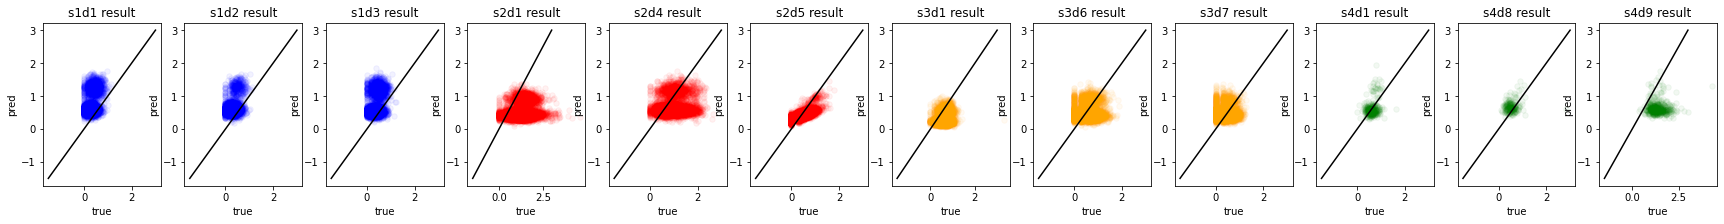

Epoch  1100 s1d1:  0.5278703 s1d2:  0.42957214 s1d3:  0.4482685 s2d1: 0.8619076 s2d4: 0.5531661 s2d5: 0.20703478 s3d1: 0.3561354 s3d6: 0.3455258 s3d7: 0.30645847 s4d1: 0.25747973 s4d8: 0.31844053 s4d9: 0.84910095 test: 0.61160433 calc test: 0.6116043207291916
Epoch  1200 s1d1:  0.53169143 s1d2:  0.43489757 s1d3:  0.4517551 s2d1: 0.86216074 s2d4: 0.55289155 s2d5: 0.1984512 s3d1: 0.35982502 s3d6: 0.34723097 s3d7: 0.30780786 s4d1: 0.25942272 s4d8: 0.3247965 s4d9: 0.8480473 test: 0.6118993 calc test: 0.611899367368171
Epoch  1300 s1d1:  0.53158855 s1d2:  0.4378775 s1d3:  0.45173648 s2d1: 0.86366487 s2d4: 0.5530249 s2d5: 0.18980682 s3d1: 0.36386716 s3d6: 0.34872052 s3d7: 0.30837312 s4d1: 0.2600881 s4d8: 0.33006236 s4d9: 0.8484295 test: 0.6128195 calc test: 0.6128194545599737
Epoch  1400 s1d1:  0.53385764 s1d2:  0.44242218 s1d3:  0.454059 s2d1: 0.8644138 s2d4: 0.5529239 s2d5: 0.18116347 s3d1: 0.36728823 s3d6: 0.35032222 s3d7: 0.3097747 s4d1: 0.2619121 s4d8: 0.3361748 s4d9: 0.84802854 test: 0

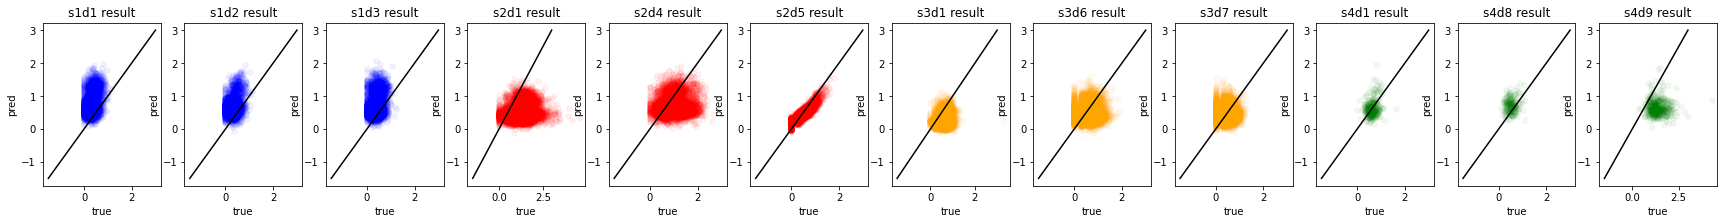

Epoch  2100 s1d1:  0.54029536 s1d2:  0.46379402 s1d3:  0.4604061 s2d1: 0.8703491 s2d4: 0.5555539 s2d5: 0.12588453 s3d1: 0.3842469 s3d6: 0.360205 s3d7: 0.31904316 s4d1: 0.27472022 s4d8: 0.37005925 s4d9: 0.8501685 test: 0.62073654 calc test: 0.6207364832470966
Epoch  2200 s1d1:  0.5419507 s1d2:  0.46677583 s1d3:  0.46188807 s2d1: 0.87077135 s2d4: 0.55591524 s2d5: 0.119090386 s3d1: 0.38555956 s3d6: 0.36131534 s3d7: 0.32051012 s4d1: 0.27672628 s4d8: 0.3739909 s4d9: 0.8503312 test: 0.6216235 calc test: 0.6216234804703853
Epoch  2300 s1d1:  0.54359573 s1d2:  0.47021523 s1d3:  0.4631044 s2d1: 0.87046564 s2d4: 0.55577546 s2d5: 0.11261047 s3d1: 0.38628072 s3d6: 0.36207137 s3d7: 0.3219166 s4d1: 0.27814487 s4d8: 0.37832832 s4d9: 0.8492198 test: 0.621681 calc test: 0.6216808904767419
Epoch  2400 s1d1:  0.5439423 s1d2:  0.4718965 s1d3:  0.46322617 s2d1: 0.8710664 s2d4: 0.5564081 s2d5: 0.106448844 s3d1: 0.38752958 s3d6: 0.3630675 s3d7: 0.32297543 s4d1: 0.27965727 s4d8: 0.38123727 s4d9: 0.84999 test:

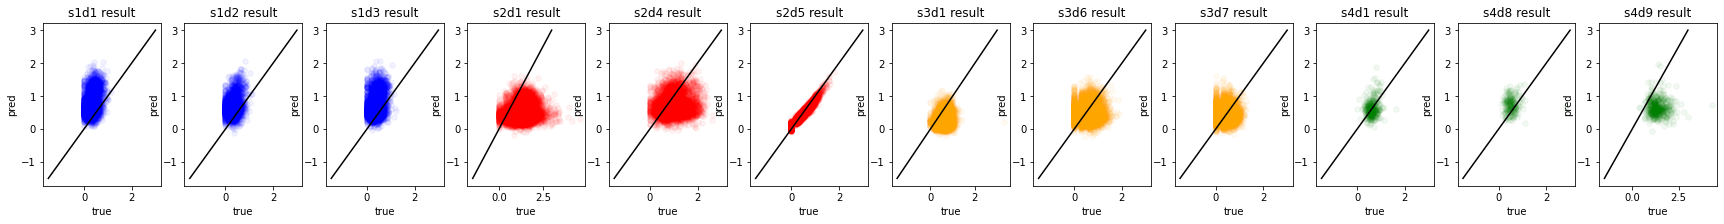

Epoch  3100 s1d1:  0.54838604 s1d2:  0.481668 s1d3:  0.46684048 s2d1: 0.87290615 s2d4: 0.55962247 s2d5: 0.0717233 s3d1: 0.39144567 s3d6: 0.36750895 s3d7: 0.327937 s4d1: 0.2876952 s4d8: 0.39461315 s4d9: 0.8518448 test: 0.626855 calc test: 0.6268549856102932
Epoch  3200 s1d1:  0.55177563 s1d2:  0.48688284 s1d3:  0.46941164 s2d1: 0.8703467 s2d4: 0.5578295 s2d5: 0.06787529 s3d1: 0.38995385 s3d6: 0.36721864 s3d7: 0.3296893 s4d1: 0.28826398 s4d8: 0.39922836 s4d9: 0.8473008 test: 0.6247168 calc test: 0.6247168342115772
Epoch  3300 s1d1:  0.5486311 s1d2:  0.4845095 s1d3:  0.46671414 s2d1: 0.8728182 s2d4: 0.5594265 s2d5: 0.06420512 s3d1: 0.3913822 s3d6: 0.3677121 s3d7: 0.32900676 s4d1: 0.28831023 s4d8: 0.3980297 s4d9: 0.85051906 test: 0.6265702 calc test: 0.6265701666384328
Epoch  3400 s1d1:  0.5497056 s1d2:  0.48503935 s1d3:  0.4673816 s2d1: 0.87315905 s2d4: 0.55983555 s2d5: 0.060798354 s3d1: 0.39193636 s3d6: 0.36826715 s3d7: 0.32924578 s4d1: 0.2894762 s4d8: 0.3990217 s4d9: 0.8509212 test: 0.6

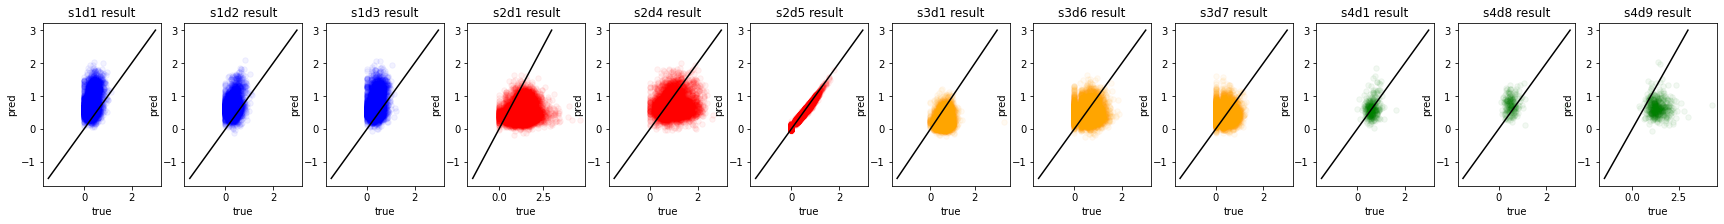

Epoch  4100 s1d1:  0.55192316 s1d2:  0.4883843 s1d3:  0.46812433 s2d1: 0.87396014 s2d4: 0.5608478 s2d5: 0.04226961 s3d1: 0.39274713 s3d6: 0.36967027 s3d7: 0.33092785 s4d1: 0.29245555 s4d8: 0.40395376 s4d9: 0.8508824 test: 0.6282209 calc test: 0.6282208861402127
Epoch  4200 s1d1:  0.5550091 s1d2:  0.49082145 s1d3:  0.47116533 s2d1: 0.87291145 s2d4: 0.56040627 s2d5: 0.04019755 s3d1: 0.39207476 s3d6: 0.36973596 s3d7: 0.33166528 s4d1: 0.29345134 s4d8: 0.4052762 s4d9: 0.8492005 test: 0.6275073 calc test: 0.6275072951220486
Epoch  4300 s1d1:  0.5551321 s1d2:  0.4930184 s1d3:  0.4708484 s2d1: 0.8720213 s2d4: 0.5592595 s2d5: 0.038273927 s3d1: 0.39139283 s3d6: 0.36929694 s3d7: 0.33249077 s4d1: 0.29309765 s4d8: 0.4079115 s4d9: 0.846727 test: 0.6262702 calc test: 0.6262701509759057
Epoch  4400 s1d1:  0.55417764 s1d2:  0.49197045 s1d3:  0.4697574 s2d1: 0.8730641 s2d4: 0.55988485 s2d5: 0.036500826 s3d1: 0.39206564 s3d6: 0.3695482 s3d7: 0.33211318 s4d1: 0.2930955 s4d8: 0.40752214 s4d9: 0.84780484 te

In [37]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s2d5, pro_s2d5)

Epoch  0 s1d1:  0.32787666 s1d2:  0.31716427 s1d3:  0.37364465 s2d1: 1.2609786 s2d4: 1.0058248 s2d5: 0.476882 s3d1: 0.56212753 s3d6: 0.55704963 s3d7: 0.36981955 s4d1: 0.5887251 s4d8: 0.5122746 s4d9: 1.3669373 test: 1.0137727 calc test: 1.0137726823959714


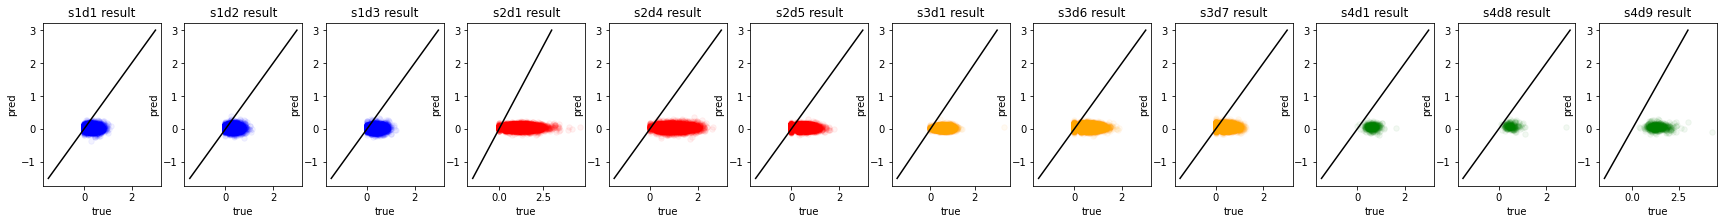

Epoch  100 s1d1:  0.8331757 s1d2:  0.8376008 s1d3:  0.7614588 s2d1: 0.6142273 s2d4: 0.48408896 s2d5: 0.4776767 s3d1: 0.19548336 s3d6: 0.48581132 s3d7: 0.6011154 s4d1: 0.53679085 s4d8: 0.7233785 s4d9: 0.45377702 test: 0.54687536 calc test: 0.5468754774636501
Epoch  200 s1d1:  0.8255766 s1d2:  0.8426541 s1d3:  0.7508804 s2d1: 0.61593634 s2d4: 0.48344296 s2d5: 0.4790327 s3d1: 0.19153273 s3d6: 0.4889011 s3d7: 0.6021878 s4d1: 0.54408073 s4d8: 0.7427212 s4d9: 0.44481516 test: 0.55125153 calc test: 0.5512516178839377
Epoch  300 s1d1:  0.8175832 s1d2:  0.8436283 s1d3:  0.74263185 s2d1: 0.61790323 s2d4: 0.4825974 s2d5: 0.48028898 s3d1: 0.18843792 s3d6: 0.4907827 s3d7: 0.6028035 s4d1: 0.5467467 s4d8: 0.75185996 s4d9: 0.44081938 test: 0.55322015 calc test: 0.5532202762239442
Epoch  400 s1d1:  0.80970985 s1d2:  0.84159434 s1d3:  0.73525524 s2d1: 0.6199518 s2d4: 0.48171216 s2d5: 0.48032972 s3d1: 0.1857375 s3d6: 0.4914594 s3d7: 0.6022436 s4d1: 0.5462421 s4d8: 0.75517154 s4d9: 0.43916345 test: 0.5533

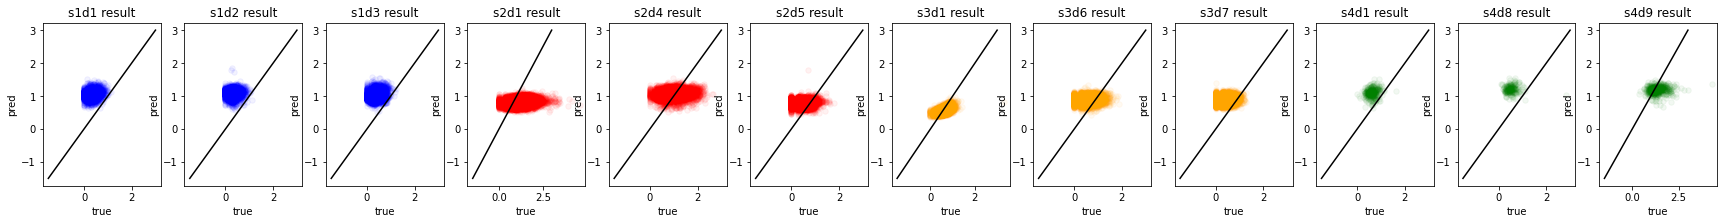

Epoch  1100 s1d1:  0.7604623 s1d2:  0.8031875 s1d3:  0.69353795 s2d1: 0.63177866 s2d4: 0.47476235 s2d5: 0.4724303 s3d1: 0.1696385 s3d6: 0.4867524 s3d7: 0.59180415 s4d1: 0.5220378 s4d8: 0.7347013 s4d9: 0.44583243 test: 0.5422105 calc test: 0.5422106467206477
Epoch  1200 s1d1:  0.75564253 s1d2:  0.798423 s1d3:  0.6896711 s2d1: 0.63274604 s2d4: 0.47431055 s2d5: 0.47171333 s3d1: 0.16737415 s3d6: 0.48659235 s3d7: 0.591275 s4d1: 0.5193372 s4d8: 0.7317794 s4d9: 0.44705766 test: 0.5409881 calc test: 0.5409881938080849
Epoch  1300 s1d1:  0.75005466 s1d2:  0.792597 s1d3:  0.6851348 s2d1: 0.63411546 s2d4: 0.47362274 s2d5: 0.47032845 s3d1: 0.16508585 s3d6: 0.48573658 s3d7: 0.5899038 s4d1: 0.5156832 s4d8: 0.7276143 s4d9: 0.4487323 test: 0.53929144 calc test: 0.5392915113614242
Epoch  1400 s1d1:  0.744969 s1d2:  0.7871573 s1d3:  0.6810557 s2d1: 0.6353892 s2d4: 0.473025 s2d5: 0.46902984 s3d1: 0.1627811 s3d6: 0.48498693 s3d7: 0.58869886 s4d1: 0.5123503 s4d8: 0.72384655 s4d9: 0.45028153 test: 0.5377714

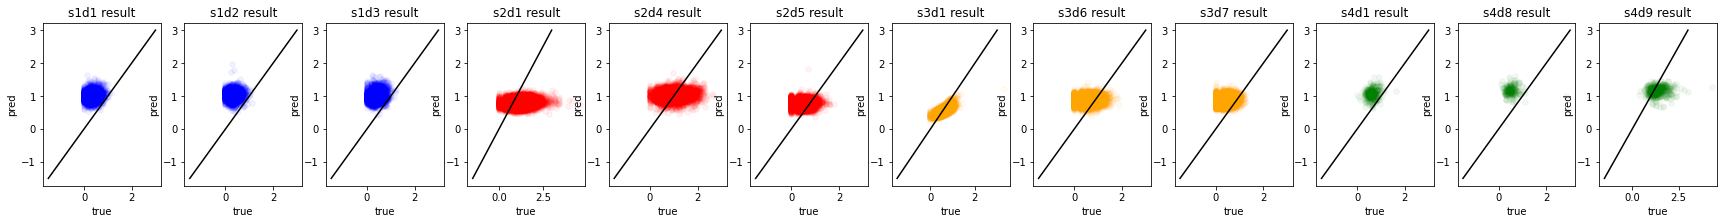

Epoch  2100 s1d1:  0.72258925 s1d2:  0.762747 s1d3:  0.6636636 s2d1: 0.64154494 s2d4: 0.4722607 s2d5: 0.46430132 s3d1: 0.1459401 s3d6: 0.4848151 s3d7: 0.5873692 s4d1: 0.5008149 s4d8: 0.7088775 s4d9: 0.458741 test: 0.5332774 calc test: 0.5332775079733919
Epoch  2200 s1d1:  0.72099274 s1d2:  0.7606823 s1d3:  0.66246456 s2d1: 0.64218247 s2d4: 0.4723818 s2d5: 0.46378323 s3d1: 0.14346485 s3d6: 0.4850735 s3d7: 0.58750975 s4d1: 0.50046307 s4d8: 0.7079844 s4d9: 0.45970878 test: 0.533304 calc test: 0.5333041089884373
Epoch  2300 s1d1:  0.71926534 s1d2:  0.75892794 s1d3:  0.6610194 s2d1: 0.64297897 s2d4: 0.4726288 s2d5: 0.46344513 s3d1: 0.14097725 s3d6: 0.4854522 s3d7: 0.58785075 s4d1: 0.50029206 s4d8: 0.70744 s4d9: 0.46068716 test: 0.53348833 calc test: 0.5334884646221278
Epoch  2400 s1d1:  0.71843594 s1d2:  0.7580062 s1d3:  0.66046774 s2d1: 0.6433555 s2d4: 0.47309595 s2d5: 0.46343684 s3d1: 0.1384748 s3d6: 0.48633853 s3d7: 0.58867633 s4d1: 0.50101185 s4d8: 0.7077777 s4d9: 0.46130842 test: 0.534

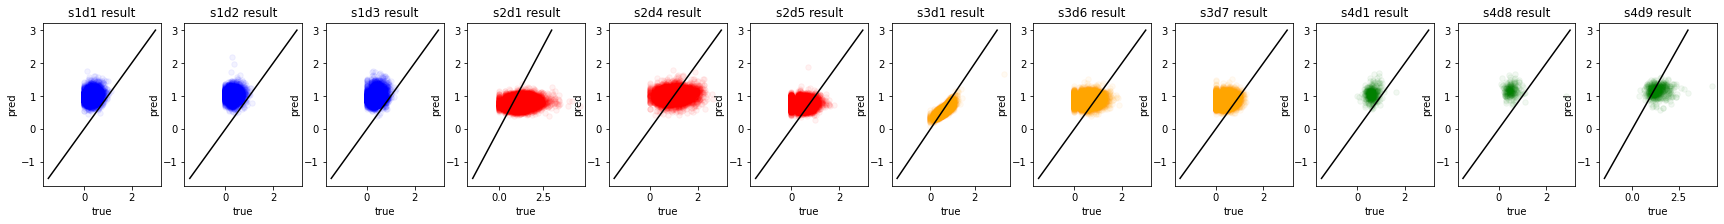

Epoch  3100 s1d1:  0.7175203 s1d2:  0.7577802 s1d3:  0.66018504 s2d1: 0.6460759 s2d4: 0.47693795 s2d5: 0.46454138 s3d1: 0.12102309 s3d6: 0.49292785 s3d7: 0.5949709 s4d1: 0.50959426 s4d8: 0.7138562 s4d9: 0.46475723 test: 0.5397815 calc test: 0.5397816015400402
Epoch  3200 s1d1:  0.71793413 s1d2:  0.7584581 s1d3:  0.6604052 s2d1: 0.6463942 s2d4: 0.47764844 s2d5: 0.46480846 s3d1: 0.118568726 s3d6: 0.49409446 s3d7: 0.59619975 s4d1: 0.51128143 s4d8: 0.71547794 s4d9: 0.46518853 test: 0.5409282 calc test: 0.5409282523019799
Epoch  3300 s1d1:  0.7183928 s1d2:  0.7594577 s1d3:  0.6607583 s2d1: 0.6468192 s2d4: 0.47834754 s2d5: 0.46521086 s3d1: 0.116132125 s3d6: 0.49518922 s3d7: 0.59720963 s4d1: 0.51312965 s4d8: 0.717247 s4d9: 0.46544352 test: 0.5420971 calc test: 0.5420971564292919
Epoch  3400 s1d1:  0.7193249 s1d2:  0.7606803 s1d3:  0.6616127 s2d1: 0.6469736 s2d4: 0.4791171 s2d5: 0.4656426 s3d1: 0.11371431 s3d6: 0.49646136 s3d7: 0.5984726 s4d1: 0.51521784 s4d8: 0.71918684 s4d9: 0.46566033 test:

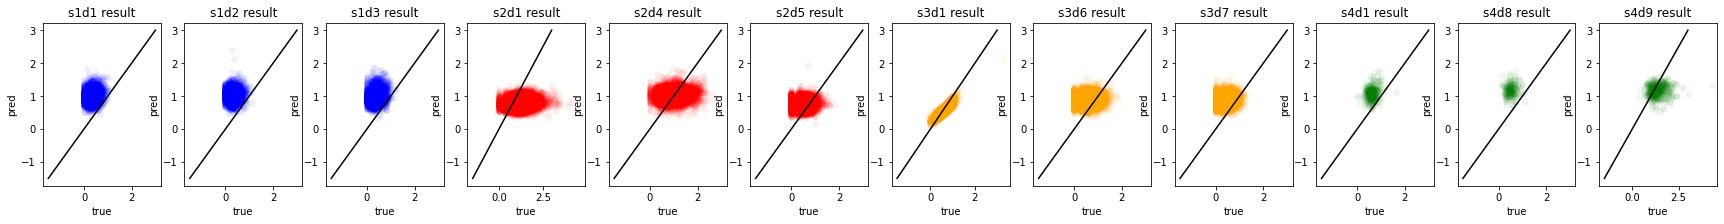

Epoch  4100 s1d1:  0.7265055 s1d2:  0.7703678 s1d3:  0.6671127 s2d1: 0.6483648 s2d4: 0.48449618 s2d5: 0.46844652 s3d1: 0.09752712 s3d6: 0.50463325 s3d7: 0.6063516 s4d1: 0.52961695 s4d8: 0.7332931 s4d9: 0.46712366 test: 0.55240256 calc test: 0.5524026564544698
Epoch  4200 s1d1:  0.72855896 s1d2:  0.7730122 s1d3:  0.668847 s2d1: 0.64807856 s2d4: 0.48550075 s2d5: 0.4695101 s3d1: 0.09533093 s3d6: 0.5064342 s3d7: 0.608079 s4d1: 0.53275275 s4d8: 0.73667705 s4d9: 0.46670124 test: 0.55417496 calc test: 0.5541750559778315
Epoch  4300 s1d1:  0.72961354 s1d2:  0.7743076 s1d3:  0.66991645 s2d1: 0.6482629 s2d4: 0.48618028 s2d5: 0.4697801 s3d1: 0.09317481 s3d6: 0.50738984 s3d7: 0.60887605 s4d1: 0.53454673 s4d8: 0.7381936 s4d9: 0.46695065 test: 0.55526507 calc test: 0.555265142249352
Epoch  4400 s1d1:  0.729336 s1d2:  0.7743877 s1d3:  0.66925603 s2d1: 0.64899 s2d4: 0.48665896 s2d5: 0.46945935 s3d1: 0.09106228 s3d6: 0.5077061 s3d7: 0.6091532 s4d1: 0.53513366 s4d8: 0.7388335 s4d9: 0.46769825 test: 0.55

In [38]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s3d1, pro_s3d1)

Epoch  0 s1d1:  0.26949596 s1d2:  0.25069815 s1d3:  0.31063083 s2d1: 1.2048554 s2d4: 0.9342469 s2d5: 0.42718515 s3d1: 0.5301941 s3d6: 0.5005378 s3d7: 0.3229227 s4d1: 0.5072305 s4d8: 0.43152025 s4d9: 1.2761759 test: 0.93381834 calc test: 0.9338183161260986


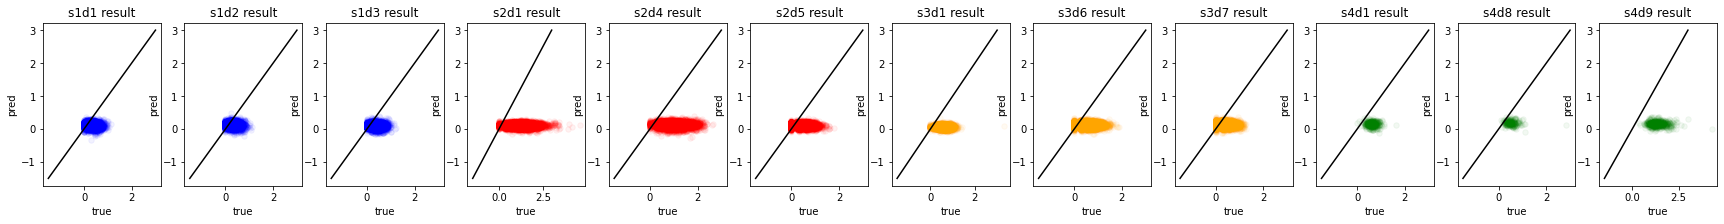

Epoch  100 s1d1:  0.37825993 s1d2:  0.37621185 s1d3:  0.34086838 s2d1: 0.8661622 s2d4: 0.5534222 s2d5: 0.30174515 s3d1: 0.30472934 s3d6: 0.29842234 s3d7: 0.30384165 s4d1: 0.19844888 s4d8: 0.30506518 s4d9: 0.7968115 test: 0.5690703 calc test: 0.5690703265486184
Epoch  200 s1d1:  0.37197757 s1d2:  0.3684499 s1d3:  0.33691663 s2d1: 0.8607915 s2d4: 0.5577186 s2d5: 0.30701494 s3d1: 0.29727212 s3d6: 0.290581 s3d7: 0.30848813 s4d1: 0.20080018 s4d8: 0.30506063 s4d9: 0.8046326 test: 0.5743718 calc test: 0.5743718210997316
Epoch  300 s1d1:  0.36981785 s1d2:  0.36543596 s1d3:  0.3353964 s2d1: 0.8569027 s2d4: 0.5599395 s2d5: 0.31027845 s3d1: 0.29255775 s3d6: 0.28398663 s3d7: 0.31160107 s4d1: 0.20236407 s4d8: 0.30492374 s4d9: 0.80951816 test: 0.5776816 calc test: 0.5776815433797143
Epoch  400 s1d1:  0.37018842 s1d2:  0.3651637 s1d3:  0.3356862 s2d1: 0.8537998 s2d4: 0.5605803 s2d5: 0.31269443 s3d1: 0.28903311 s3d6: 0.2776159 s3d7: 0.3146074 s4d1: 0.20388085 s4d8: 0.30564946 s4d9: 0.8122627 test: 0.5

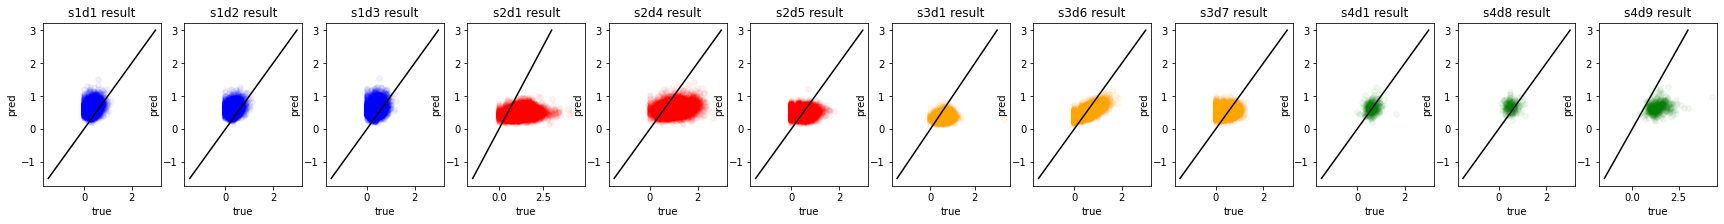

Epoch  1100 s1d1:  0.39130735 s1d2:  0.39027664 s1d3:  0.3485771 s2d1: 0.8534139 s2d4: 0.5562732 s2d5: 0.32262 s3d1: 0.2899351 s3d6: 0.22504318 s3d7: 0.33141768 s4d1: 0.21999101 s4d8: 0.33186787 s4d9: 0.8076127 test: 0.58166987 calc test: 0.5816699019686115
Epoch  1200 s1d1:  0.39661378 s1d2:  0.39636493 s1d3:  0.35250664 s2d1: 0.85344374 s2d4: 0.55461067 s2d5: 0.32437697 s3d1: 0.29114893 s3d6: 0.21650197 s3d7: 0.33443737 s4d1: 0.22395308 s4d8: 0.33843765 s4d9: 0.8035734 test: 0.5803893 calc test: 0.5803893012590007
Epoch  1300 s1d1:  0.39933324 s1d2:  0.39949214 s1d3:  0.35405344 s2d1: 0.8550287 s2d4: 0.55459553 s2d5: 0.32549828 s3d1: 0.29337034 s3d6: 0.20789172 s3d7: 0.3360126 s4d1: 0.22752161 s4d8: 0.34359545 s4d9: 0.8019322 test: 0.58043826 calc test: 0.580438252401311
Epoch  1400 s1d1:  0.40227416 s1d2:  0.40229648 s1d3:  0.35607183 s2d1: 0.8569577 s2d4: 0.55480415 s2d5: 0.32656264 s3d1: 0.2958508 s3d6: 0.19929133 s3d7: 0.33710873 s4d1: 0.23132712 s4d8: 0.34823212 s4d9: 0.8005515 

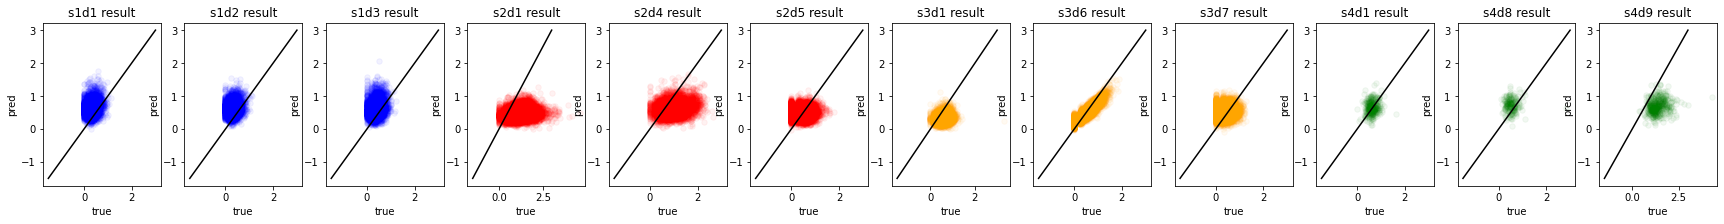

Epoch  2100 s1d1:  0.4225733 s1d2:  0.4253879 s1d3:  0.37014627 s2d1: 0.8648764 s2d4: 0.5562146 s2d5: 0.3348154 s3d1: 0.31001475 s3d6: 0.14341639 s3d7: 0.34599325 s4d1: 0.25589833 s4d8: 0.38277903 s4d9: 0.78710526 test: 0.5801445 calc test: 0.5801445060921124
Epoch  2200 s1d1:  0.42337933 s1d2:  0.42737344 s1d3:  0.37027413 s2d1: 0.86666864 s2d4: 0.55739 s2d5: 0.3356302 s3d1: 0.31215015 s3d6: 0.13644545 s3d7: 0.346406 s4d1: 0.2582718 s4d8: 0.3863536 s4d9: 0.7863761 test: 0.5805323 calc test: 0.5805323176919602
Epoch  2300 s1d1:  0.42250386 s1d2:  0.42692447 s1d3:  0.3690018 s2d1: 0.8698798 s2d4: 0.5596045 s2d5: 0.3357713 s3d1: 0.31483054 s3d6: 0.12978047 s3d7: 0.34547248 s4d1: 0.26002136 s4d8: 0.387941 s4d9: 0.7878586 test: 0.5819332 calc test: 0.5819332051231852
Epoch  2400 s1d1:  0.42765614 s1d2:  0.4324735 s1d3:  0.3730409 s2d1: 0.86869603 s2d4: 0.55775607 s2d5: 0.33702183 s3d1: 0.31526387 s3d6: 0.123376876 s3d7: 0.34760717 s4d1: 0.2631404 s4d8: 0.39351985 s4d9: 0.78367406 test: 0.5

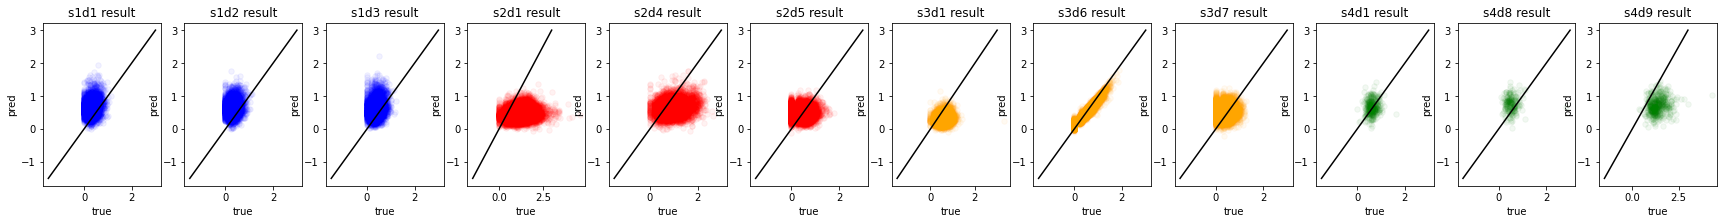

Epoch  3100 s1d1:  0.43654665 s1d2:  0.44411734 s1d3:  0.3784156 s2d1: 0.8743047 s2d4: 0.55926377 s2d5: 0.34022972 s3d1: 0.32246467 s3d6: 0.08676162 s3d7: 0.35102677 s4d1: 0.27442682 s4d8: 0.41083455 s4d9: 0.77895546 test: 0.5818936 calc test: 0.5818936574220842
Epoch  3200 s1d1:  0.43771392 s1d2:  0.4455764 s1d3:  0.3792014 s2d1: 0.8742164 s2d4: 0.5589902 s2d5: 0.34075084 s3d1: 0.3227285 s3d6: 0.08258347 s3d7: 0.35169354 s4d1: 0.2756555 s4d8: 0.41305625 s4d9: 0.77757525 test: 0.5815658 calc test: 0.5815658066602785
Epoch  3300 s1d1:  0.4374822 s1d2:  0.4448151 s1d3:  0.37904736 s2d1: 0.8760496 s2d4: 0.55999035 s2d5: 0.34058887 s3d1: 0.32401538 s3d6: 0.07869309 s3d7: 0.35080665 s4d1: 0.27621406 s4d8: 0.41320717 s4d9: 0.778671 test: 0.5823489 calc test: 0.5823489362610094
Epoch  3400 s1d1:  0.43938538 s1d2:  0.44775677 s1d3:  0.38021052 s2d1: 0.87545836 s2d4: 0.5589828 s2d5: 0.3412221 s3d1: 0.3241108 s3d6: 0.074930795 s3d7: 0.35202426 s4d1: 0.2775686 s4d8: 0.41651455 s4d9: 0.7760615 tes

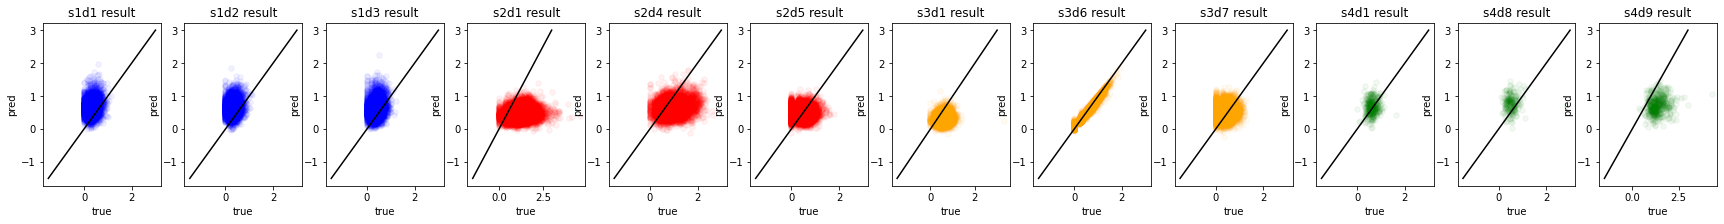

Epoch  4100 s1d1:  0.44125974 s1d2:  0.4515269 s1d3:  0.3799972 s2d1: 0.87841743 s2d4: 0.55929047 s2d5: 0.34185392 s3d1: 0.32683524 s3d6: 0.05444098 s3d7: 0.35356718 s4d1: 0.28147644 s4d8: 0.4233186 s4d9: 0.774537 test: 0.58216333 calc test: 0.5821633584678274
Epoch  4200 s1d1:  0.44622505 s1d2:  0.4576947 s1d3:  0.3839706 s2d1: 0.87468225 s2d4: 0.5560337 s2d5: 0.3433004 s3d1: 0.32490608 s3d6: 0.052190278 s3d7: 0.35691044 s4d1: 0.2838771 s4d8: 0.4292444 s4d9: 0.76872706 test: 0.57991177 calc test: 0.5799118571654032
Epoch  4300 s1d1:  0.44397095 s1d2:  0.4548125 s1d3:  0.38180035 s2d1: 0.87701434 s2d4: 0.55753356 s2d5: 0.3424658 s3d1: 0.32631388 s3d6: 0.049933184 s3d7: 0.3551656 s4d1: 0.28317395 s4d8: 0.42712763 s4d9: 0.7713052 test: 0.58104366 calc test: 0.5810436790385185
Epoch  4400 s1d1:  0.443364 s1d2:  0.45385286 s1d3:  0.38144362 s2d1: 0.8782317 s2d4: 0.5583656 s2d5: 0.3421649 s3d1: 0.3270078 s3d6: 0.04794523 s3d7: 0.35435286 s4d1: 0.28314653 s4d8: 0.42623213 s4d9: 0.772606 test

In [39]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s3d6, pro_s3d6)

Epoch  0 s1d1:  0.3176621 s1d2:  0.30169696 s1d3:  0.36413172 s2d1: 1.2525783 s2d4: 0.99218607 s2d5: 0.46600214 s3d1: 0.5588317 s3d6: 0.5457543 s3d7: 0.35699847 s4d1: 0.5724862 s4d8: 0.49378 s4d9: 1.3494595 test: 0.9978946 calc test: 0.9978945796651956


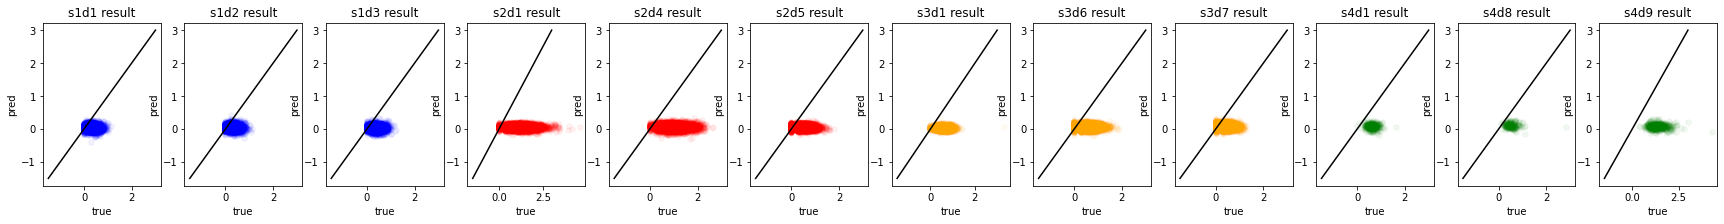

Epoch  100 s1d1:  0.22493379 s1d2:  0.22993813 s1d3:  0.2090694 s2d1: 1.0107496 s2d4: 0.6943158 s2d5: 0.3144908 s3d1: 0.40156293 s3d6: 0.3550179 s3d7: 0.24241461 s4d1: 0.26025844 s4d8: 0.25343686 s4d9: 0.97938573 test: 0.6900653 calc test: 0.6900652930119224
Epoch  200 s1d1:  0.22386838 s1d2:  0.23179857 s1d3:  0.2076747 s2d1: 1.0136104 s2d4: 0.69669056 s2d5: 0.31464314 s3d1: 0.40141037 s3d6: 0.35568044 s3d7: 0.2369817 s4d1: 0.26220736 s4d8: 0.25344932 s4d9: 0.98031104 test: 0.6909152 calc test: 0.6909152191700496
Epoch  300 s1d1:  0.22391972 s1d2:  0.23333812 s1d3:  0.2076347 s2d1: 1.0154476 s2d4: 0.69878155 s2d5: 0.31488758 s3d1: 0.40136653 s3d6: 0.35626784 s3d7: 0.23215854 s4d1: 0.2649537 s4d8: 0.2542347 s4d9: 0.9819961 test: 0.6924216 calc test: 0.6924216001215892
Epoch  400 s1d1:  0.22370188 s1d2:  0.2339581 s1d3:  0.20755075 s2d1: 1.0175332 s2d4: 0.7019406 s2d5: 0.3154294 s3d1: 0.40167668 s3d6: 0.35710153 s3d7: 0.22744323 s4d1: 0.26879713 s4d8: 0.25536636 s4d9: 0.9848373 test: 0.

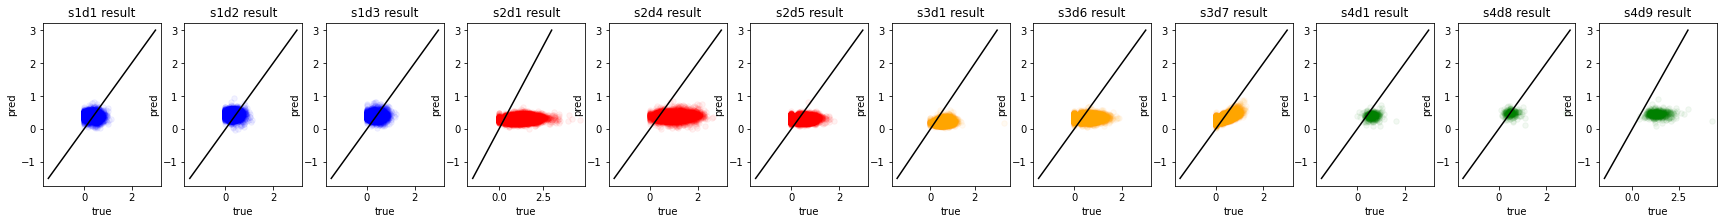

Epoch  1100 s1d1:  0.23007238 s1d2:  0.24167219 s1d3:  0.21420424 s2d1: 1.0277327 s2d4: 0.71976066 s2d5: 0.32019782 s3d1: 0.40507418 s3d6: 0.36253098 s3d7: 0.19052222 s4d1: 0.2924423 s4d8: 0.2648084 s4d9: 0.9971062 test: 0.70670176 calc test: 0.706701768957446
Epoch  1200 s1d1:  0.2312497 s1d2:  0.24283713 s1d3:  0.21551894 s2d1: 1.0297698 s2d4: 0.722272 s2d5: 0.32129088 s3d1: 0.40640348 s3d6: 0.36370552 s3d7: 0.18467803 s4d1: 0.29613674 s4d8: 0.26644033 s4d9: 0.99890214 test: 0.70850444 calc test: 0.7085044281283325
Epoch  1300 s1d1:  0.23314004 s1d2:  0.2449604 s1d3:  0.21727867 s2d1: 1.0309168 s2d4: 0.72353786 s2d5: 0.3221374 s3d1: 0.40727162 s3d6: 0.36437473 s3d7: 0.17875922 s4d1: 0.29867446 s4d8: 0.2678068 s4d9: 0.99932766 test: 0.7092419 calc test: 0.709241918640079
Epoch  1400 s1d1:  0.23449026 s1d2:  0.24637885 s1d3:  0.2187091 s2d1: 1.0326152 s2d4: 0.72519165 s2d5: 0.3232932 s3d1: 0.40852833 s3d6: 0.36546925 s3d7: 0.17282858 s4d1: 0.30162823 s4d8: 0.26918676 s4d9: 1.0005084 te

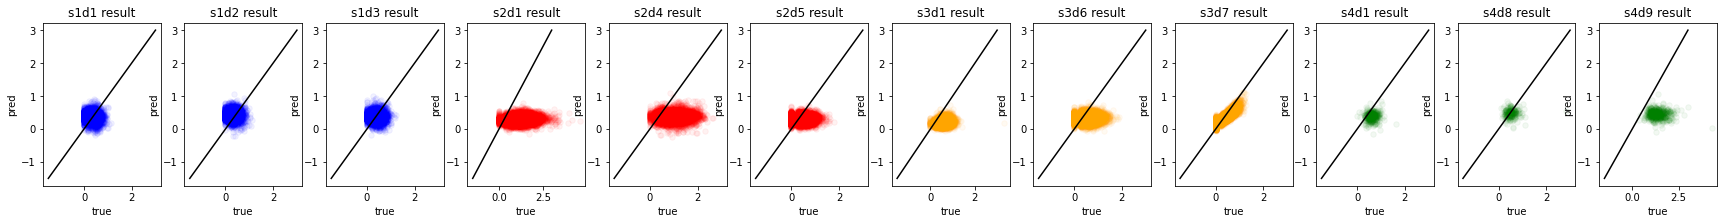

Epoch  2100 s1d1:  0.24453904 s1d2:  0.25661296 s1d3:  0.22904743 s2d1: 1.0427331 s2d4: 0.7350449 s2d5: 0.33113146 s3d1: 0.41684008 s3d6: 0.3727688 s3d7: 0.13308641 s4d1: 0.3184324 s4d8: 0.27958027 s4d9: 1.0076187 test: 0.71837884 calc test: 0.7183787943313928
Epoch  2200 s1d1:  0.2448659 s1d2:  0.2567297 s1d3:  0.22971855 s2d1: 1.0449308 s2d4: 0.737402 s2d5: 0.3327296 s3d1: 0.41864532 s3d6: 0.37446877 s3d7: 0.12793736 s4d1: 0.32147923 s4d8: 0.28115845 s4d9: 1.0102084 test: 0.72062546 calc test: 0.7206254234037702
Epoch  2300 s1d1:  0.24695145 s1d2:  0.25940108 s1d3:  0.23133902 s2d1: 1.0442398 s2d4: 0.73629564 s2d5: 0.3328615 s3d1: 0.41840878 s3d6: 0.37424573 s3d7: 0.122895375 s4d1: 0.32115775 s4d8: 0.28210163 s4d9: 1.0085093 test: 0.71956074 calc test: 0.7195606964321574
Epoch  2400 s1d1:  0.24781835 s1d2:  0.26020405 s1d3:  0.23222396 s2d1: 1.0451931 s2d4: 0.7371447 s2d5: 0.3338566 s3d1: 0.4193652 s3d6: 0.37524846 s3d7: 0.11802814 s4d1: 0.32269785 s4d8: 0.28331992 s4d9: 1.0092626 te

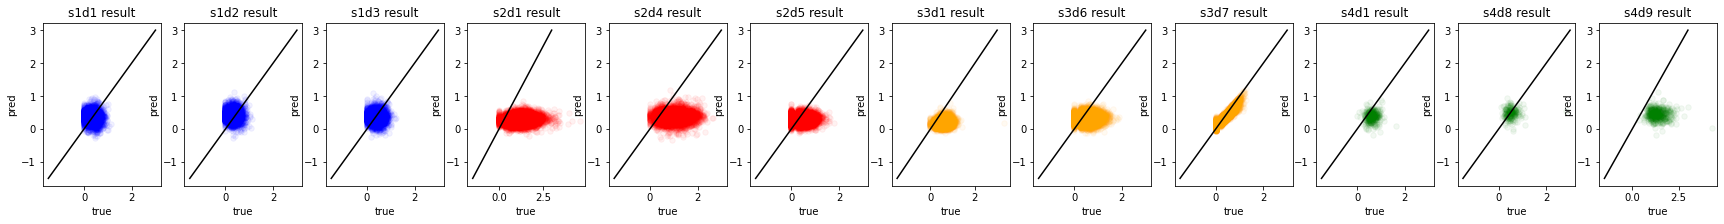

Epoch  3100 s1d1:  0.2536592 s1d2:  0.26760298 s1d3:  0.23714128 s2d1: 1.04749 s2d4: 0.737256 s2d5: 0.33755392 s3d1: 0.42240196 s3d6: 0.37833977 s3d7: 0.088679634 s4d1: 0.32661954 s4d8: 0.28985712 s4d9: 1.0086266 test: 0.7210938 calc test: 0.7210936975375783
Epoch  3200 s1d1:  0.25333074 s1d2:  0.2668667 s1d3:  0.23716837 s2d1: 1.0489726 s2d4: 0.73862505 s2d5: 0.33857146 s3d1: 0.42349237 s3d6: 0.3794947 s3d7: 0.08513466 s4d1: 0.3284013 s4d8: 0.2908304 s4d9: 1.0105934 test: 0.7227073 calc test: 0.7227072852749005
Epoch  3300 s1d1:  0.25376216 s1d2:  0.26743555 s1d3:  0.23763916 s2d1: 1.0497744 s2d4: 0.7392826 s2d5: 0.3391406 s3d1: 0.42419198 s3d6: 0.38005635 s3d7: 0.081741475 s4d1: 0.3292065 s4d8: 0.2916919 s4d9: 1.0109042 test: 0.7231009 calc test: 0.7231009023926256
Epoch  3400 s1d1:  0.2543025 s1d2:  0.26842508 s1d3:  0.23793797 s2d1: 1.0496303 s2d4: 0.73846275 s2d5: 0.33932737 s3d1: 0.42413986 s3d6: 0.38008237 s3d7: 0.078483544 s4d1: 0.3288826 s4d8: 0.2923015 s4d9: 1.0103363 test: 0

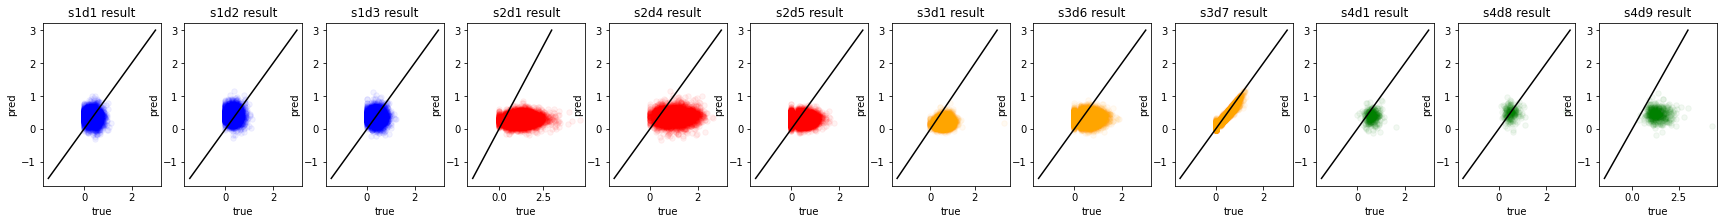

Epoch  4100 s1d1:  0.25587127 s1d2:  0.27130896 s1d3:  0.23891729 s2d1: 1.050225 s2d4: 0.73663646 s2d5: 0.3407075 s3d1: 0.42496014 s3d6: 0.3813237 s3d7: 0.059565768 s4d1: 0.3288036 s4d8: 0.2957088 s4d9: 1.0092176 test: 0.72229564 calc test: 0.7222956294774519
Epoch  4200 s1d1:  0.25671715 s1d2:  0.2724313 s1d3:  0.239436 s2d1: 1.0501419 s2d4: 0.7361695 s2d5: 0.34065703 s3d1: 0.42492908 s3d6: 0.3811269 s3d7: 0.057335842 s4d1: 0.32844648 s4d8: 0.29608357 s4d9: 1.0080732 test: 0.7215392 calc test: 0.721539216520869
Epoch  4300 s1d1:  0.25636408 s1d2:  0.2718832 s1d3:  0.23940577 s2d1: 1.0516487 s2d4: 0.7379519 s2d5: 0.34116802 s3d1: 0.42592138 s3d6: 0.38193545 s3d7: 0.055265587 s4d1: 0.3299086 s4d8: 0.29680327 s4d9: 1.0099717 test: 0.7230403 calc test: 0.7230402664756381
Epoch  4400 s1d1:  0.25610164 s1d2:  0.2716875 s1d3:  0.23907216 s2d1: 1.0512372 s2d4: 0.73709327 s2d5: 0.3412673 s3d1: 0.4257016 s3d6: 0.3820124 s3d7: 0.053239845 s4d1: 0.3295935 s4d8: 0.29688445 s4d9: 1.0100098 test: 0.

In [40]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s3d7, pro_s3d7)

Epoch  0 s1d1:  0.39176598 s1d2:  0.4361139 s1d3:  0.34427065 s2d1: 0.8917168 s2d4: 0.5873527 s2d5: 0.3102574 s3d1: 0.348097 s3d6: 0.32488862 s3d7: 0.32398668 s4d1: 0.23938675 s4d8: 0.37091514 s4d9: 0.76773936 test: 0.56406057 calc test: 0.5640605906734223


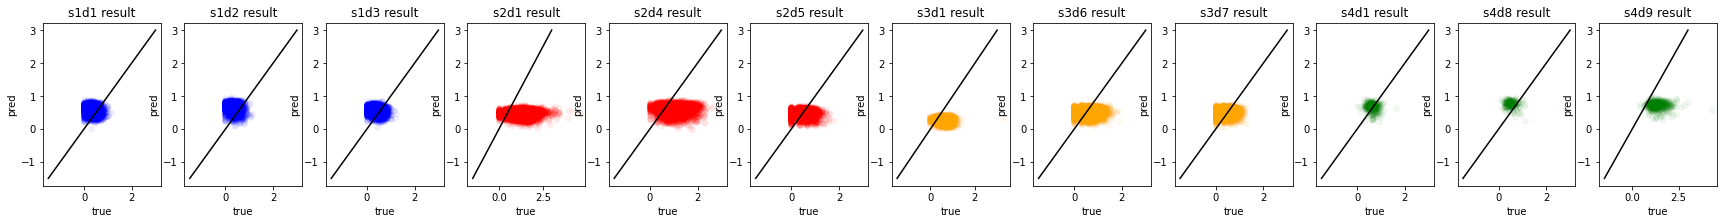

Epoch  100 s1d1:  0.913601 s1d2:  0.95430225 s1d3:  0.8896118 s2d1: 0.5732552 s2d4: 0.5102159 s2d5: 0.61021185 s3d1: 0.21755004 s3d6: 0.57126206 s3d7: 0.63889396 s4d1: 0.6905954 s4d8: 0.8715257 s4d9: 0.23835254 test: 0.5853177 calc test: 0.5853178025725696
Epoch  200 s1d1:  0.90909916 s1d2:  0.93409896 s1d3:  0.8948375 s2d1: 0.5656165 s2d4: 0.51336795 s2d5: 0.63893145 s3d1: 0.2336241 s3d6: 0.59077305 s3d7: 0.6573717 s4d1: 0.7018097 s4d8: 0.8706402 s4d9: 0.101563856 test: 0.5710962 calc test: 0.5710962939368808
Epoch  300 s1d1:  0.91532624 s1d2:  0.9397099 s1d3:  0.8964371 s2d1: 0.56297797 s2d4: 0.5179574 s2d5: 0.64473516 s3d1: 0.23650646 s3d6: 0.59927243 s3d7: 0.6722306 s4d1: 0.71025795 s4d8: 0.882183 s4d9: 0.0515828 test: 0.57516086 calc test: 0.5751609922046436
Epoch  400 s1d1:  0.9071676 s1d2:  0.92924595 s1d3:  0.8863613 s2d1: 0.5648802 s2d4: 0.51511204 s2d5: 0.6385323 s3d1: 0.23545992 s3d6: 0.59503233 s3d7: 0.6693695 s4d1: 0.7019864 s4d8: 0.87384945 s4d9: 0.03346514 test: 0.568482

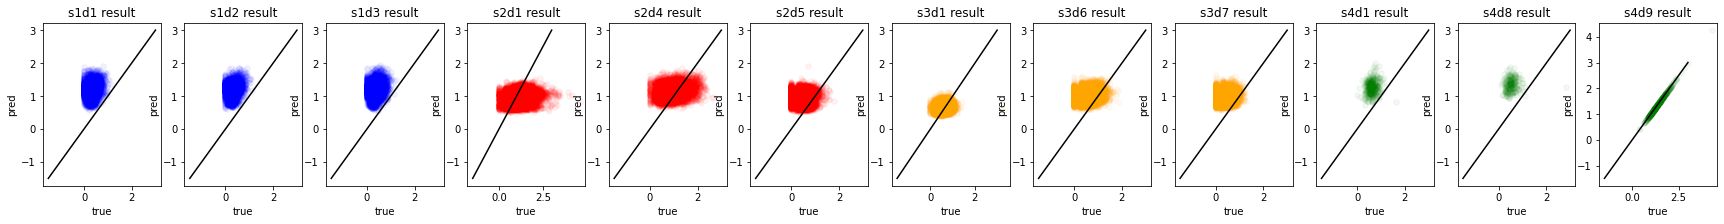

Epoch  1100 s1d1:  0.9042015 s1d2:  0.92748845 s1d3:  0.8816311 s2d1: 0.56319755 s2d4: 0.5166248 s2d5: 0.64302045 s3d1: 0.24145713 s3d6: 0.6015824 s3d7: 0.679915 s4d1: 0.7066758 s4d8: 0.8805198 s4d9: 0.008292853 test: 0.57211727 calc test: 0.5721173777505194
Epoch  1200 s1d1:  0.8977786 s1d2:  0.91893125 s1d3:  0.8754085 s2d1: 0.56497097 s2d4: 0.51346445 s2d5: 0.6374444 s3d1: 0.23998457 s3d6: 0.5961424 s3d7: 0.67407423 s4d1: 0.6985773 s4d8: 0.87013763 s4d9: 0.009367796 test: 0.5654763 calc test: 0.5654764125776527
Epoch  1300 s1d1:  0.90464735 s1d2:  0.9253792 s1d3:  0.88139576 s2d1: 0.56222767 s2d4: 0.51663053 s2d5: 0.64114875 s3d1: 0.24167491 s3d6: 0.6010232 s3d7: 0.680068 s4d1: 0.7045443 s4d8: 0.87700224 s4d9: 0.006712708 test: 0.5701078 calc test: 0.5701078949263423
Epoch  1400 s1d1:  0.897568 s1d2:  0.91906255 s1d3:  0.87496793 s2d1: 0.5642611 s2d4: 0.51417077 s2d5: 0.6382275 s3d1: 0.2412249 s3d6: 0.5980775 s3d7: 0.6765143 s4d1: 0.6994404 s4d8: 0.8722948 s4d9: 0.0075030364 test: 0

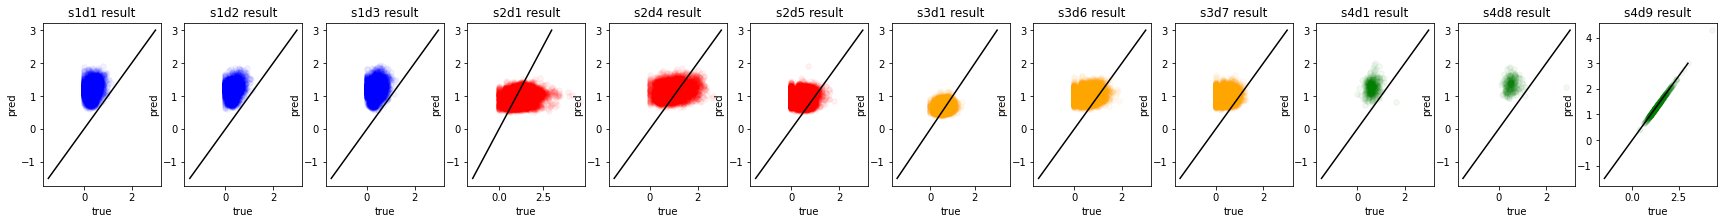

Epoch  2100 s1d1:  0.90302444 s1d2:  0.9243722 s1d3:  0.8799526 s2d1: 0.5615009 s2d4: 0.51695687 s2d5: 0.6433454 s3d1: 0.24573317 s3d6: 0.60361606 s3d7: 0.68428785 s4d1: 0.70596296 s4d8: 0.87779504 s4d9: 0.005716925 test: 0.5709409 calc test: 0.5709410263150322
Epoch  2200 s1d1:  0.9013753 s1d2:  0.92169535 s1d3:  0.877483 s2d1: 0.56151813 s2d4: 0.5159176 s2d5: 0.6409835 s3d1: 0.24515656 s3d6: 0.602226 s3d7: 0.6831851 s4d1: 0.70404553 s4d8: 0.87586737 s4d9: 0.005349724 test: 0.56953394 calc test: 0.5695340522394078
Epoch  2300 s1d1:  0.90420055 s1d2:  0.9231859 s1d3:  0.8804969 s2d1: 0.5608811 s2d4: 0.51725113 s2d5: 0.64159447 s3d1: 0.24594922 s3d6: 0.60320437 s3d7: 0.6831771 s4d1: 0.7056518 s4d8: 0.8772701 s4d9: 0.0061889244 test: 0.5706476 calc test: 0.5706477303948881
Epoch  2400 s1d1:  0.90085596 s1d2:  0.9194305 s1d3:  0.87715536 s2d1: 0.5615184 s2d4: 0.51567423 s2d5: 0.6395634 s3d1: 0.24546804 s3d6: 0.60107833 s3d7: 0.6816349 s4d1: 0.7019191 s4d8: 0.8732617 s4d9: 0.005255507 test

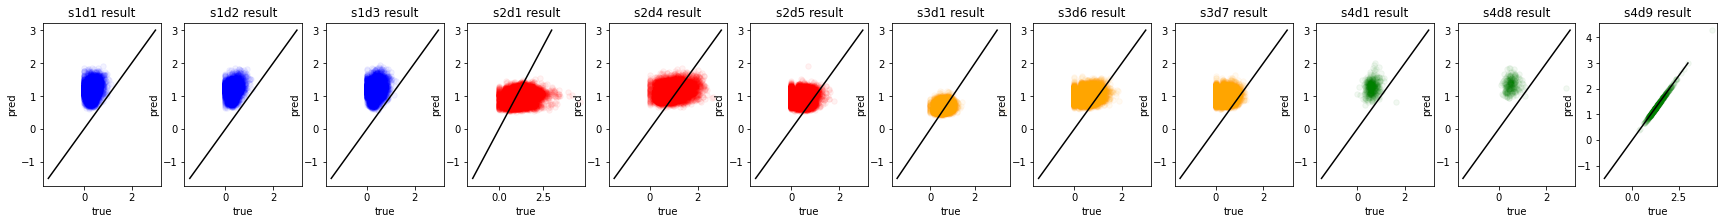

Epoch  3100 s1d1:  0.900265 s1d2:  0.9204528 s1d3:  0.8770076 s2d1: 0.5603906 s2d4: 0.51599884 s2d5: 0.64285386 s3d1: 0.24864943 s3d6: 0.6036177 s3d7: 0.68456125 s4d1: 0.7043373 s4d8: 0.8748894 s4d9: 0.004681229 test: 0.5693405 calc test: 0.569340641288172
Epoch  3200 s1d1:  0.89733535 s1d2:  0.9186733 s1d3:  0.87426 s2d1: 0.56099975 s2d4: 0.5148436 s2d5: 0.642889 s3d1: 0.24873635 s3d6: 0.6028694 s3d7: 0.6836094 s4d1: 0.70280594 s4d8: 0.873689 s4d9: 0.00560706 test: 0.5683298 calc test: 0.5683299566865737
Epoch  3300 s1d1:  0.898603 s1d2:  0.91827637 s1d3:  0.8752331 s2d1: 0.56044894 s2d4: 0.5152928 s2d5: 0.6418547 s3d1: 0.24864362 s3d6: 0.60275596 s3d7: 0.68367773 s4d1: 0.70238966 s4d8: 0.87269837 s4d9: 0.0044976342 test: 0.56783813 calc test: 0.5678382712699522
Epoch  3400 s1d1:  0.9029966 s1d2:  0.92146945 s1d3:  0.879477 s2d1: 0.559133 s2d4: 0.51728797 s2d5: 0.64368254 s3d1: 0.25009733 s3d6: 0.6052674 s3d7: 0.6864952 s4d1: 0.70563394 s4d8: 0.87539214 s4d9: 0.005120635 test: 0.57003

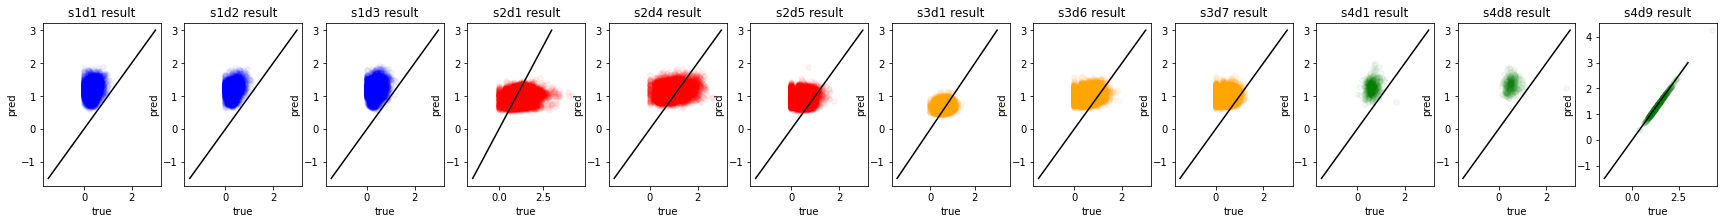

Epoch  4100 s1d1:  0.8976639 s1d2:  0.9175755 s1d3:  0.8738111 s2d1: 0.5593285 s2d4: 0.5149778 s2d5: 0.6435456 s3d1: 0.2518597 s3d6: 0.6047109 s3d7: 0.6867526 s4d1: 0.7019179 s4d8: 0.8709066 s4d9: 0.005129749 test: 0.56707585 calc test: 0.5670759331884848
Epoch  4200 s1d1:  0.89691466 s1d2:  0.9152525 s1d3:  0.8731847 s2d1: 0.55947214 s2d4: 0.51427877 s2d5: 0.641911 s3d1: 0.2514582 s3d6: 0.60289705 s3d7: 0.68497103 s4d1: 0.7000019 s4d8: 0.86803216 s4d9: 0.0070664324 test: 0.56537956 calc test: 0.5653796384312875
Epoch  4300 s1d1:  0.8999236 s1d2:  0.9185289 s1d3:  0.875895 s2d1: 0.5583582 s2d4: 0.5156403 s2d5: 0.64438486 s3d1: 0.25288445 s3d6: 0.60550815 s3d7: 0.68821555 s4d1: 0.70329165 s4d8: 0.8715595 s4d9: 0.0044772234 test: 0.5678489 calc test: 0.5678490150442501
Epoch  4400 s1d1:  0.90453327 s1d2:  0.9245305 s1d3:  0.88146144 s2d1: 0.5569818 s2d4: 0.51860577 s2d5: 0.64932984 s3d1: 0.25525808 s3d6: 0.61055183 s3d7: 0.6924273 s4d1: 0.70983565 s4d8: 0.8788479 s4d9: 0.007467613 test: 

In [41]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s4d9, pro_s4d9)